In [29]:
import numpy as np
import torch
import os
import pickle
import seaborn as sns
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import pyplot as pltf
import matplotlib as mpl
import copy
import pandas as pd

# Prepare Data

Some initial parameters

In [30]:
# data params
dataroot = "/Users/jim/Documents/RandomBergman/KS4/data/"
dataset = "h11_10"

h11 = int(dataset[-2:])
newsize = h11
diff = newsize - h11

num_geometries = 4000

# ML params
batchSize = 64
workers = 2
nz = 5
N_EPOCHS = 100
lr_D, lr_G = 0.00003, 0.00003
G_EPOCHS = 5 # number generator epochs per discriminator epoch

In [5]:
files_list = [d for d in os.listdir(dataroot) if "_"+str(h11)+"_" in d and 'K' in d]
print("TOTAL POSSIBLE GEOMS", len(files_list))
files_list = files_list[:num_geometries]
print("First five files,", files_list[:5])

raw_pickles = []
for d in files_list:
    try:
        raw_pickles.append(pickle.load(open(dataroot + d,'rb')))
    except ValueError:
        print("Error reading pickle:",d)
        
padded_raw_pickles = [torch.nn.functional.pad(torch.FloatTensor(k),(0,diff,0,diff),'constant',0).numpy() for k in raw_pickles]

# create PyTorch dataset
raw_data = torch.tensor(padded_raw_pickles).view(num_geometries,1,newsize,newsize)
dataset = torch.utils.data.TensorDataset(raw_data)

# create PyTorch dataloader that will be used for training
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                            shuffle=True, num_workers=int(workers))

('TOTAL POSSIBLE GEOMS', 9282)
('First five files,', ['h11_10_poly9087_K.pickle', 'h11_10_poly5199_K.pickle', 'h11_10_poly2058_K.pickle', 'h11_10_poly4137_K.pickle', 'h11_10_poly8029_K.pickle'])


In [6]:
n_batches = int(np.ceil(len(dataset)/ batchSize)) # 60000 / 100

# Generative Adversarial Network Design

In [7]:
from torch import nn

# Discriminator
D = nn.Sequential(
    nn.Linear(h11 * h11, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

# Generator 
class symmetric_G(nn.Module):
    def __init__(self,nz,h11):
        super(symmetric_G, self).__init__()
        self.h11 = h11
        self.nz = nz
        self.fc1, self.fc2, self.fc3, self.fc4, self.fc5 = nn.Linear(nz, 256), nn.Linear(256, 256), nn.Linear(256, 256), nn.Linear(256, 256), nn.Linear(256, self.h11*self.h11)
        self.a1, self.a2, self.a3, self.a4 = nn.LeakyReLU(0.2), nn.LeakyReLU(0.2), nn.LeakyReLU(0.2), nn.LeakyReLU(0.2)
        
    def forward(self,input):
        o1 = self.a1(self.fc1(input))
        o2 = self.a1(self.fc2(o1))
        o3 = self.a1(self.fc3(o2))
        o4 = self.a1(self.fc4(o3))
        o5 = self.fc5(o4)
        o, oT, s = o5.view(o5.shape[0],self.h11,self.h11), torch.transpose(o5.view(o5.shape[0],self.h11,self.h11),1,2), o5.shape
        m = torch.bmm(o,oT)
        return m.view(m.shape[0],self.h11*self.h11)
    
G = symmetric_G(nz,h11)
# G = nn.Sequential(
#     nn.Linear(nz, 256),
#     nn.LeakyReLU(0.2),
#     nn.Linear(256, 256),
#     nn.LeakyReLU(0.2),
#     nn.Linear(256, 256),
#     nn.LeakyReLU(0.2),
#     nn.Linear(256, 256),
#     nn.LeakyReLU(0.2),
#     nn.Linear(256, h11 * h11),
# )

# if you're running on GPU, move models there
if torch.cuda.is_available():
    D.cuda()
    G.cuda()

In [8]:
# Define your loss function and optimizer by picking from the ones already available in `torch.nn` or defining your own
criterion = nn.BCELoss() # Or remove nn.Sigmoid() and use 
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr_D)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr_G)

# Data Evaluation and Visualization Methods

In [9]:
mpl.rcParams['figure.dpi'] = 200
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
fsize = 20
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=fsize)  # controls default text sizes
plt.rc('axes', titlesize=20)  # fontsize of the axes title
plt.rc('axes', labelsize=20)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
plt.rc('legend', fontsize=14)  # legend fontsize
plt.rc('figure', titlesize=fsize)  # fontsize of the figure title

#### Imaging Methods

In [10]:
def gen_matrices(GAN, noise = None, batchSize = 64, nz = 100):
    if type(noise) == type(None):
        noise = torch.FloatTensor(batchSize, nz)
        noise.resize_(batchSize, nz).normal_(0, 1)
    
    return GAN(noise)

In [11]:
def show_GAN_image_sequence(GANlist, batchSize = 64, nz = 100, scale_factor = 1, dpi = 500):
    fixed_noise = torch.randn(batchSize, nz)
    fixed_noise.resize_(batchSize, nz).normal_(0, 1)
    for h11, epoch, GAN in GANlist:
        print "(h11, epoch):", (h11,epoch)
        show_images(gen_matrices(GAN, noise = fixed_noise, nz=nz), scale_factor = scale_factor, \
                    dpi = dpi, xlabel = r'$\mathrm{Epoch \,\,} ' + str(epoch) +'$', \
                   filename = 'images_for_paper/h11_' + str(h11) + '_nz_' +str(nz)+'_epoch_'+str(epoch)+'.png',
                   title =  r'$h^{11} = ' + str(h11) + ',\,\,\, n_z = ' + str(nz) +"$")

In [12]:
def show_images(tensor, nrow=8, padding=2, dpi=500,
               normalize=False, range=None, scale_each=False, pad_value=0, scale_factor=1, title = '', xlabel = '', filename = ''):
    sns.set_style("white")
    tensor.data = tensor.data.mul(0.5).add(0.5)
    
    size = int(np.sqrt(tensor.shape[1]))
    tensor = tensor.view(tensor.shape[0],1,size,size)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=scale_factor*size),
        transforms.ToTensor()
    ])
    tensor = [transform(x_) for x_ in tensor]
    
    img = torchvision.utils.make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    npimg = img.detach().numpy()
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.yticks([])
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
    if xlabel != '': plt.xlabel(xlabel) #xlabel(r'$\mathrm{Number\,\, of\,\, steps}$')
    if title != '': plt.title(title)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    #if filename != '': plt.savefig(filename,dpi=dpi,bbox_inches='tight',pad_inches=0.1)
    plt.show()

#### Eigenvalue Methods

In [13]:
def histogram(df_column, title, xlabel = '', kde = False, norm_hist = True, show = True, log10 = True, ylim = None,xlim=None,filename = '',dpi=500):
    sns.set_style("darkgrid")
    if log10:
        df_column = np.log10(df_column)
        df_column = df_column.replace([np.inf, -np.inf], np.nan)
        df_column = df_column.dropna()
        df_column = df_column.tolist()
        #print type(df_column)
        plot = sns.distplot(df_column, kde = kde, norm_hist = norm_hist, label = None)
    else:
        df_column = df_column.tolist()
        plot = sns.distplot(df_column, kde = kde, norm_hist = norm_hist, label = None)
    if title != '': plt.title(title)
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
    if xlabel != '': plt.xlabel(xlabel) #xlabel(r'$\mathrm{Number\,\, of\,\, steps}$') 
    if ylim != None: plt.ylim(ylim)
    if xlim != None: plt.xlim(xlim)
    #if filename != '': plt.savefig(filename,dpi=dpi,bbox_inches='tight',pad_inches=0.1)
    if show:
        plt.show()
    return plot

def histograms(df_columns, labels, kde = False, norm_hist = True, show_together = True, show_separate = False, log10 = True):
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    plt.legend(prop={'size':12})
    for idx, df_column in enumerate(df_columns): 
        histogram(df_column, labels[idx], kde = kde, norm_hist = norm_hist, show = show_separate, log10 = log10)
    if show_together: 
        plt.show()
        


In [14]:
def gen_wishart_matrices(h11, batchSize = 64):
    A = torch.randn(batchSize,h11,h11)
    AT = torch.transpose(A,1,2)
    return (torch.bmm(AT,A)/torch.tensor(1.0*h11)).view(A.shape[0],h11*h11)

def ensemble_eigenvalues(data_tensor): # data_tensor is batch of matrices
    eigs, s = [], data_tensor.shape
    size = int(np.sqrt(s[1]))
    data_tensor = data_tensor.view(s[0],size,size)
    for matrix in data_tensor:
        img_size = matrix.shape[1]
        matrix = matrix.view(img_size,img_size).detach().numpy()
        eigs.extend(np.linalg.eig(matrix)[0])
    return eigs

In [15]:
from scipy.stats import wasserstein_distance

def show_GAN_histogram(GAN, h11, nz = 100, dpi=500, noise = None, inverse_wishart = False, batchSize = 10000, kde = False, display_wishart = True, norm_hist = True, show = True, log10 = True, ylim = None, xlim = None):
    data_tensor = gen_matrices(GAN, noise = noise, batchSize = batchSize, nz = nz)
    #data_tensor = batch_upper_left(data_tensor, h11)
    eigs = ensemble_eigenvalues(data_tensor)
    eigs = [k for k in eigs if k not in [np.nan, np.inf, -np.inf]]
    wishart_eigs = ensemble_eigenvalues(gen_wishart_matrices(h11,batchSize))
#     if inverse_wishart:
#         wishart_eigs = [1/k for k in wishart_eigs]
    
    
    log_eigs, log_wishart_eigs, log_real_eigs = [k for k in np.log10(eigs) if not np.isnan(k) and k not in [np.nan, np.inf, -np.inf]], [k for k in np.log10(wishart_eigs) if not np.isnan(k) and  k not in [np.nan, np.inf, -np.inf]], [k for k in np.log10(np.array(real_eig_dfs[h11])) if not np.isnan(k) and k not in [np.nan, np.inf, -np.inf]]
    
    nologdist, logdist = wasserstein_distance(eigs,real_eig_dfs[h11]), wasserstein_distance(log_eigs, log_real_eigs)
#     print "Wasserstein Distance GAN (no log, log):", nologdist, logdist
#     print "Wasserstein Distance Wishart (no log, log):", wasserstein_distance(wishart_eigs,real_eig_dfs[h11]), wasserstein_distance(log_wishart_eigs, log_real_eigs)
    if log10:
        dist = logdist
    else:
        dist = nologdist
    
    print (dist,logdist)
    for eig in log_eigs:
       if not isinstance(eig,np.float32): print eig, type(eig), type(np.nan)
    
    title = r'$h^{11} = ' + str(h11) + ',\,\,\, n_z = ' + str(nz) +",\,\,\, \mathrm{\,\,\, \\\\ Distance = }" + str(round(dist,2)) + "$"
    xlabel = r'$\mathrm{log}_{10}(\mathrm{Eigenvalue})$'
    
    histogram(real_eig_dfs[h11], title=title, show = False, log10 = log10, norm_hist = norm_hist)
    if display_wishart:
        histogram(pd.DataFrame({h11: wishart_eigs})[h11], title=title, kde = kde, norm_hist = norm_hist, show = False, log10 = log10)
    histogram(pd.DataFrame({h11: eigs})[h11], title=title, kde = kde, norm_hist = norm_hist, show = show, log10 = log10, ylim=ylim, xlim=xlim, \
             filename = 'images_for_paper/h11_' + str(h11) + '_nz_' +str(nz)+'_epoch_'+str(epoch)+'_plot.png', xlabel = xlabel, dpi=dpi)
    
#     return wasserstein_distance(eigs,real_eig_dfs[h11]), wasserstein_distance(wishart_eigs,real_eig_dfs[h11]), wasserstein_distance(log_eigs,log_real_eigs)

Load real eigenvalues

h11, n_eigs: 10 62820
h11, n_eigs: 20 55920
h11, n_eigs: 30 36660
h11, n_eigs: 40 100800
h11, n_eigs: 50 144950


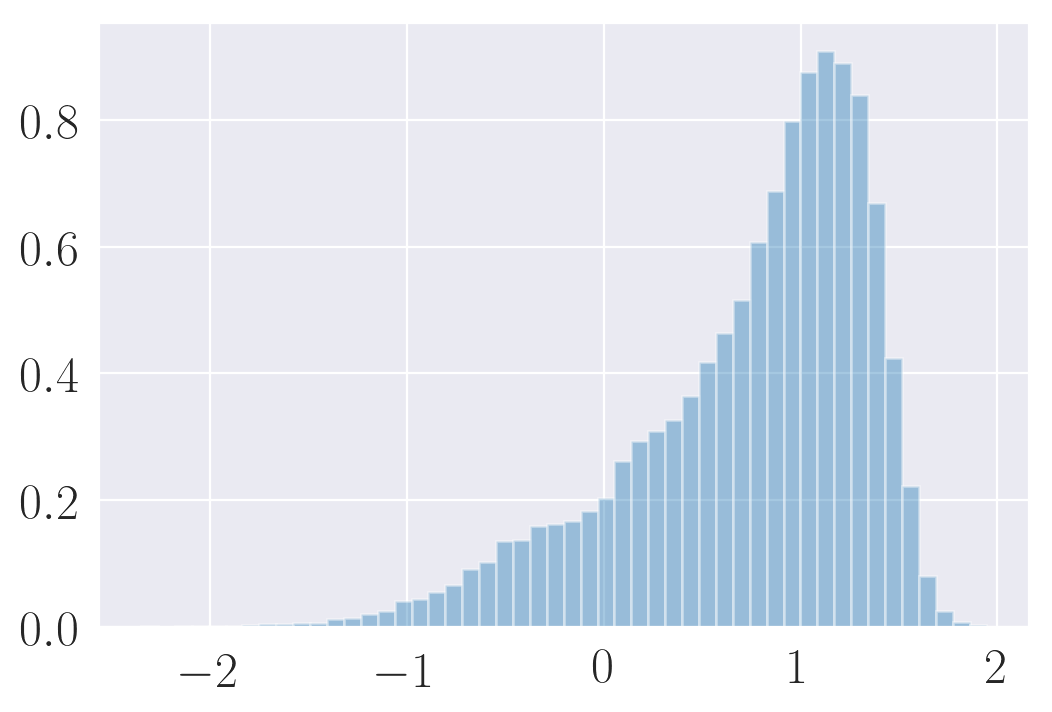

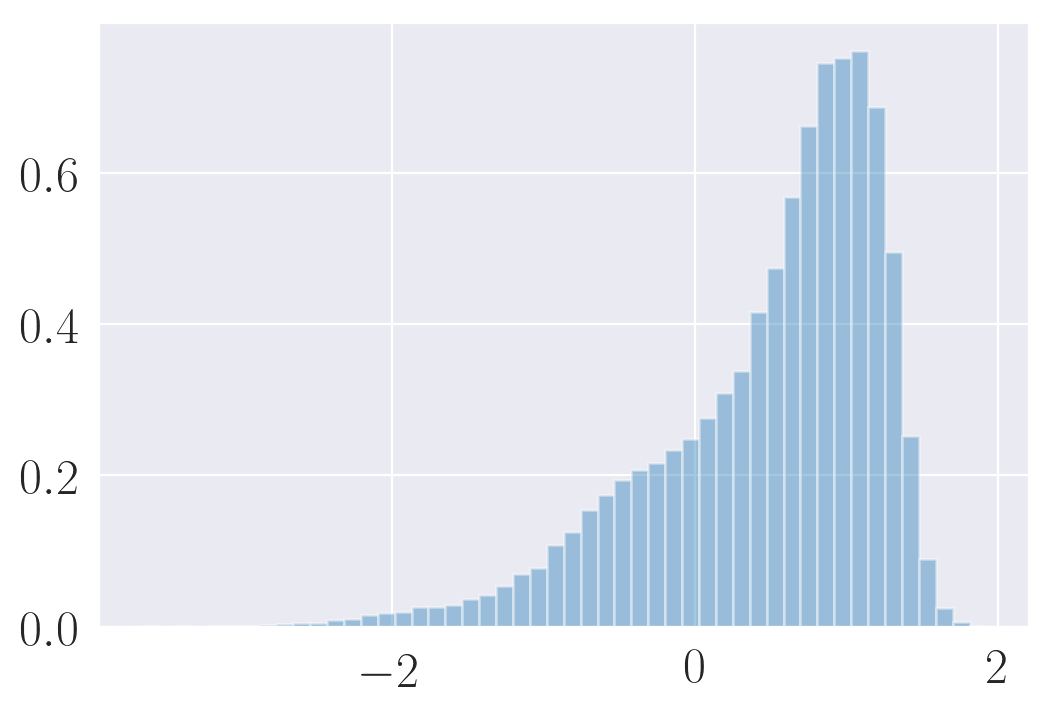

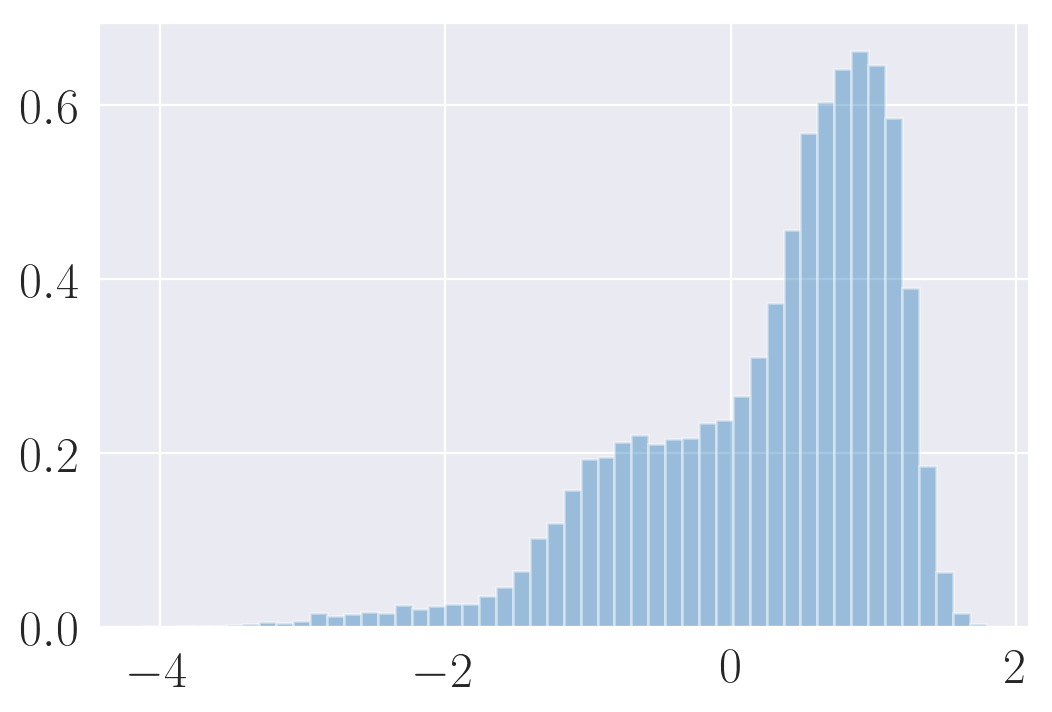

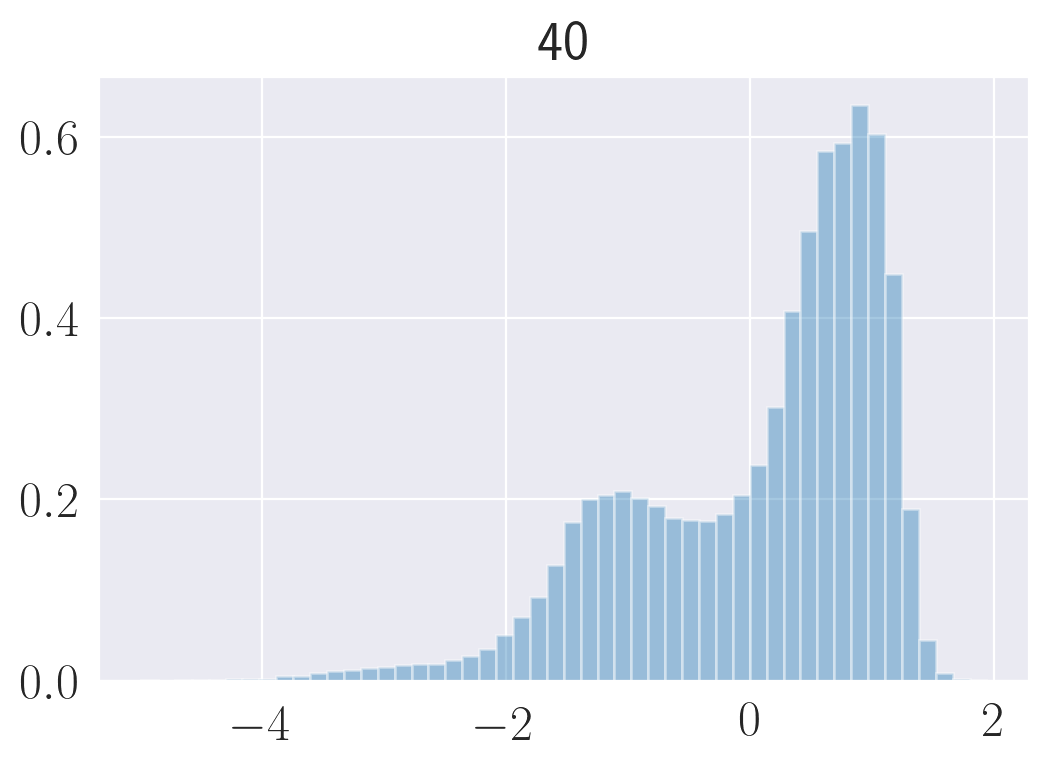

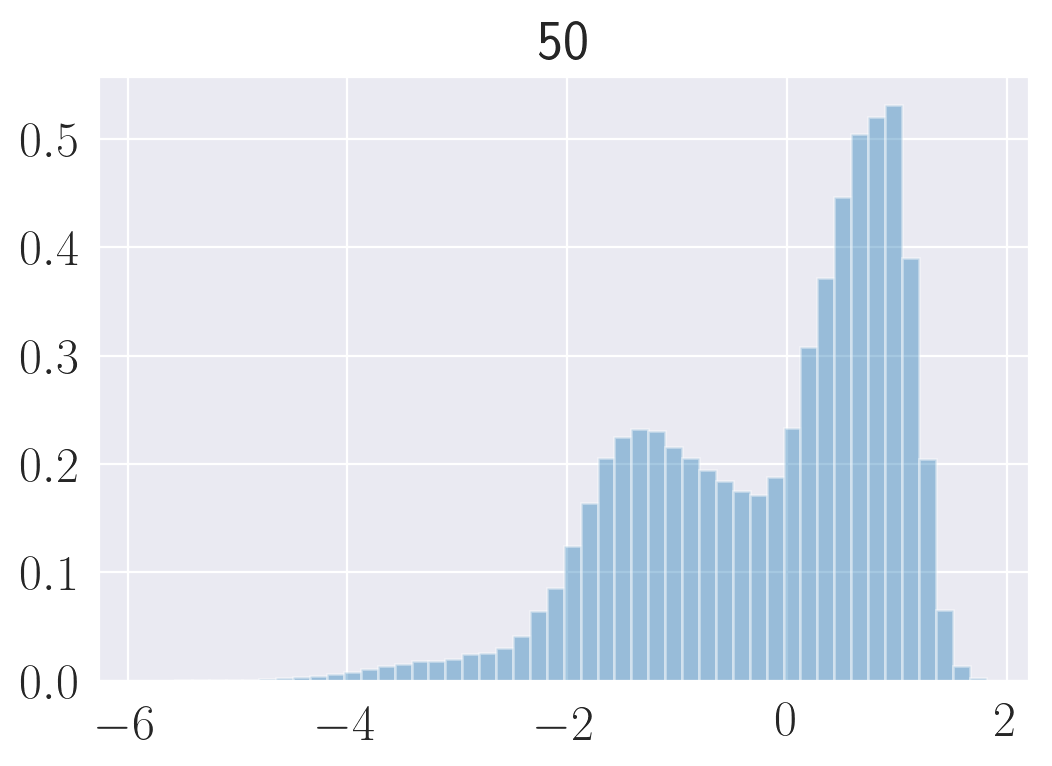

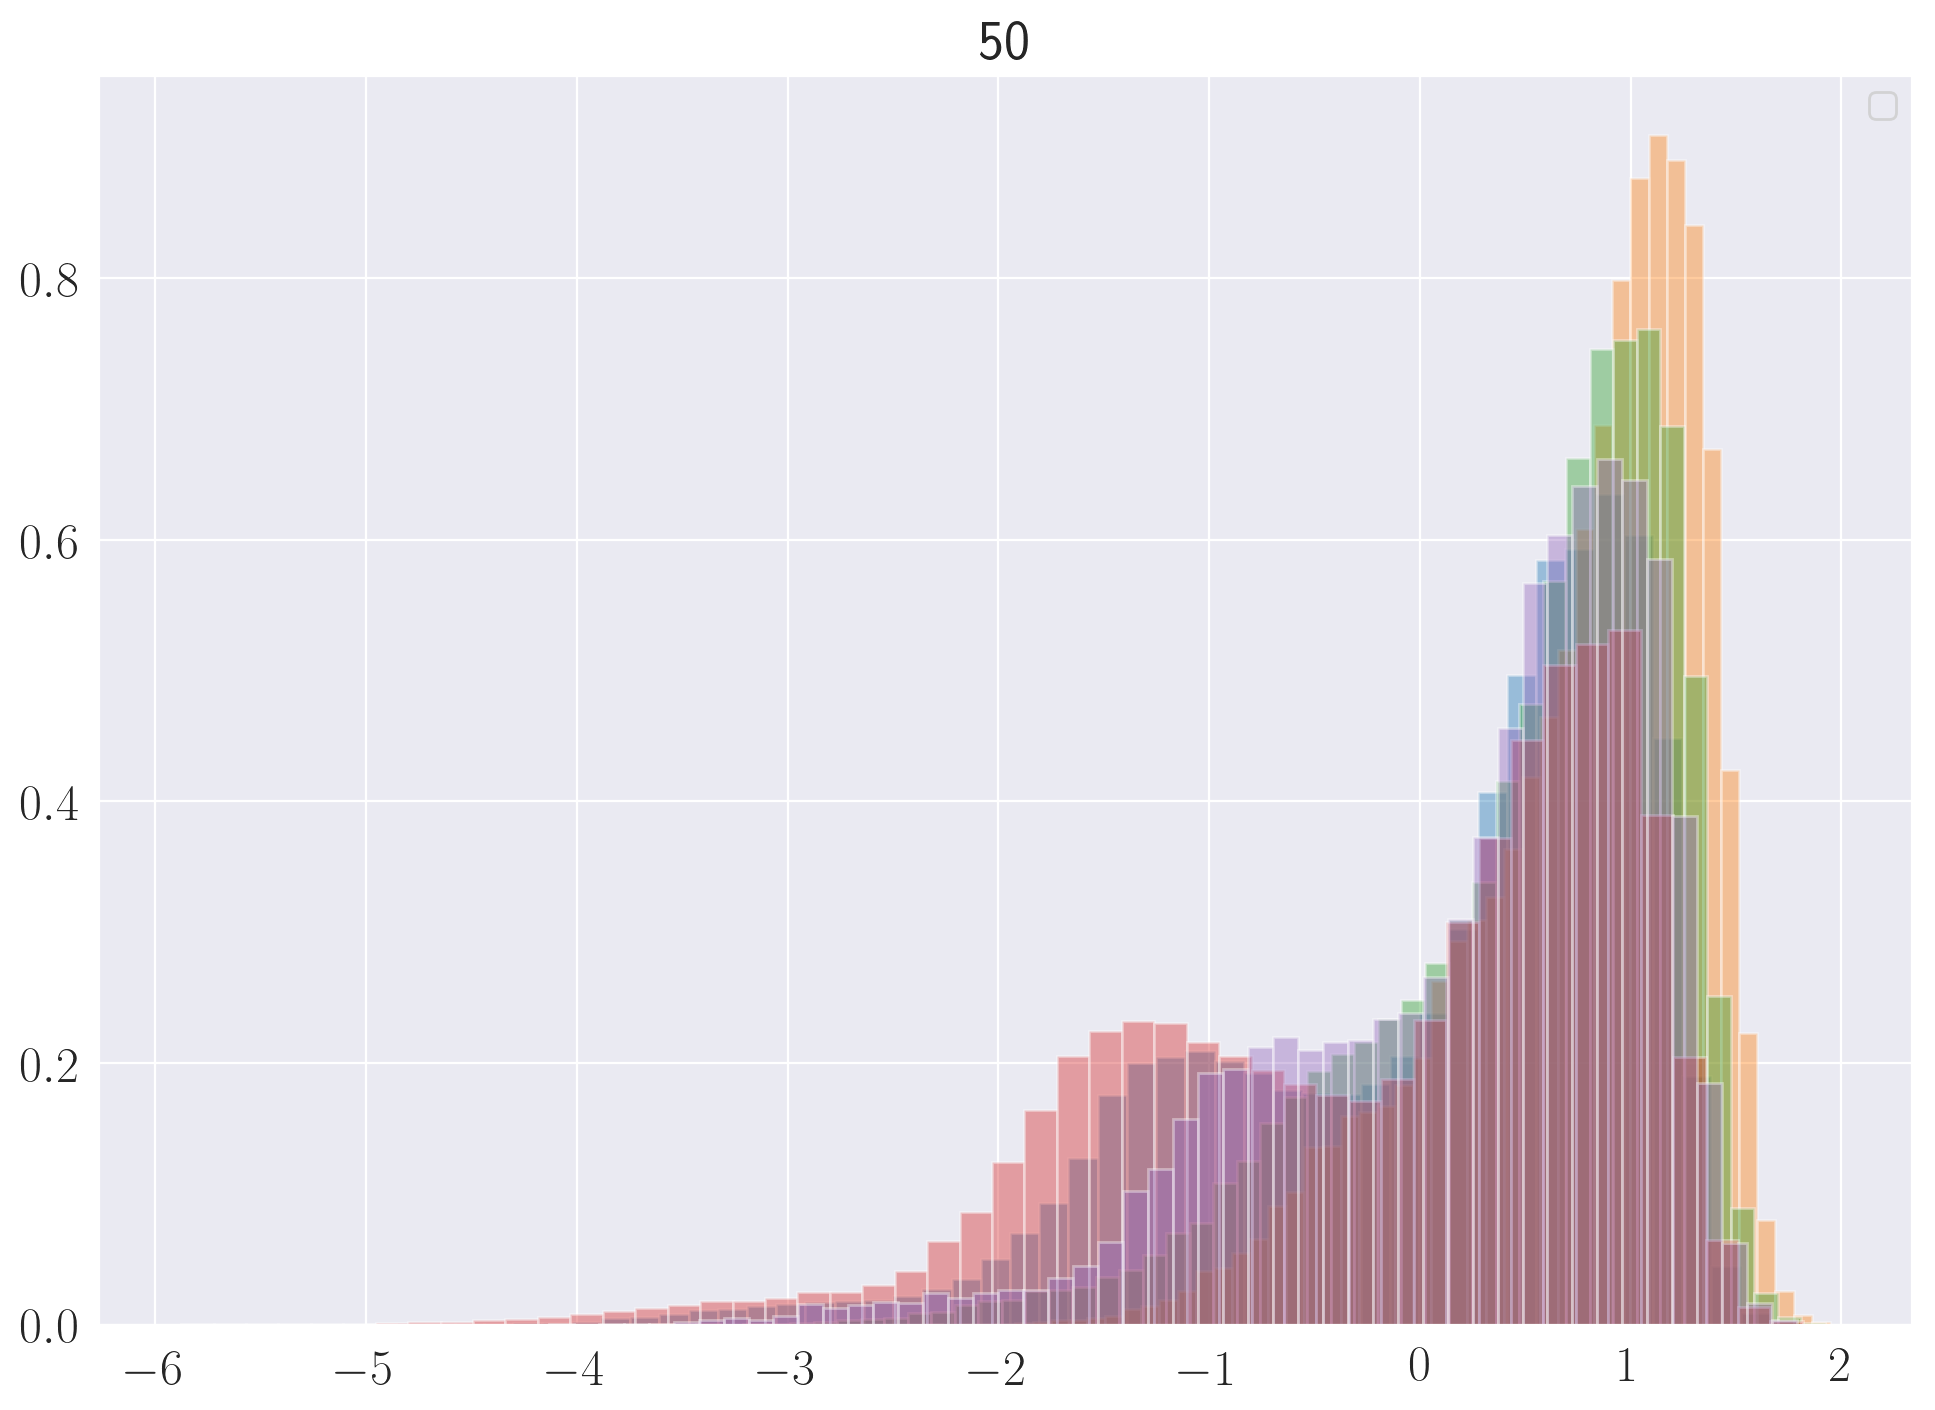

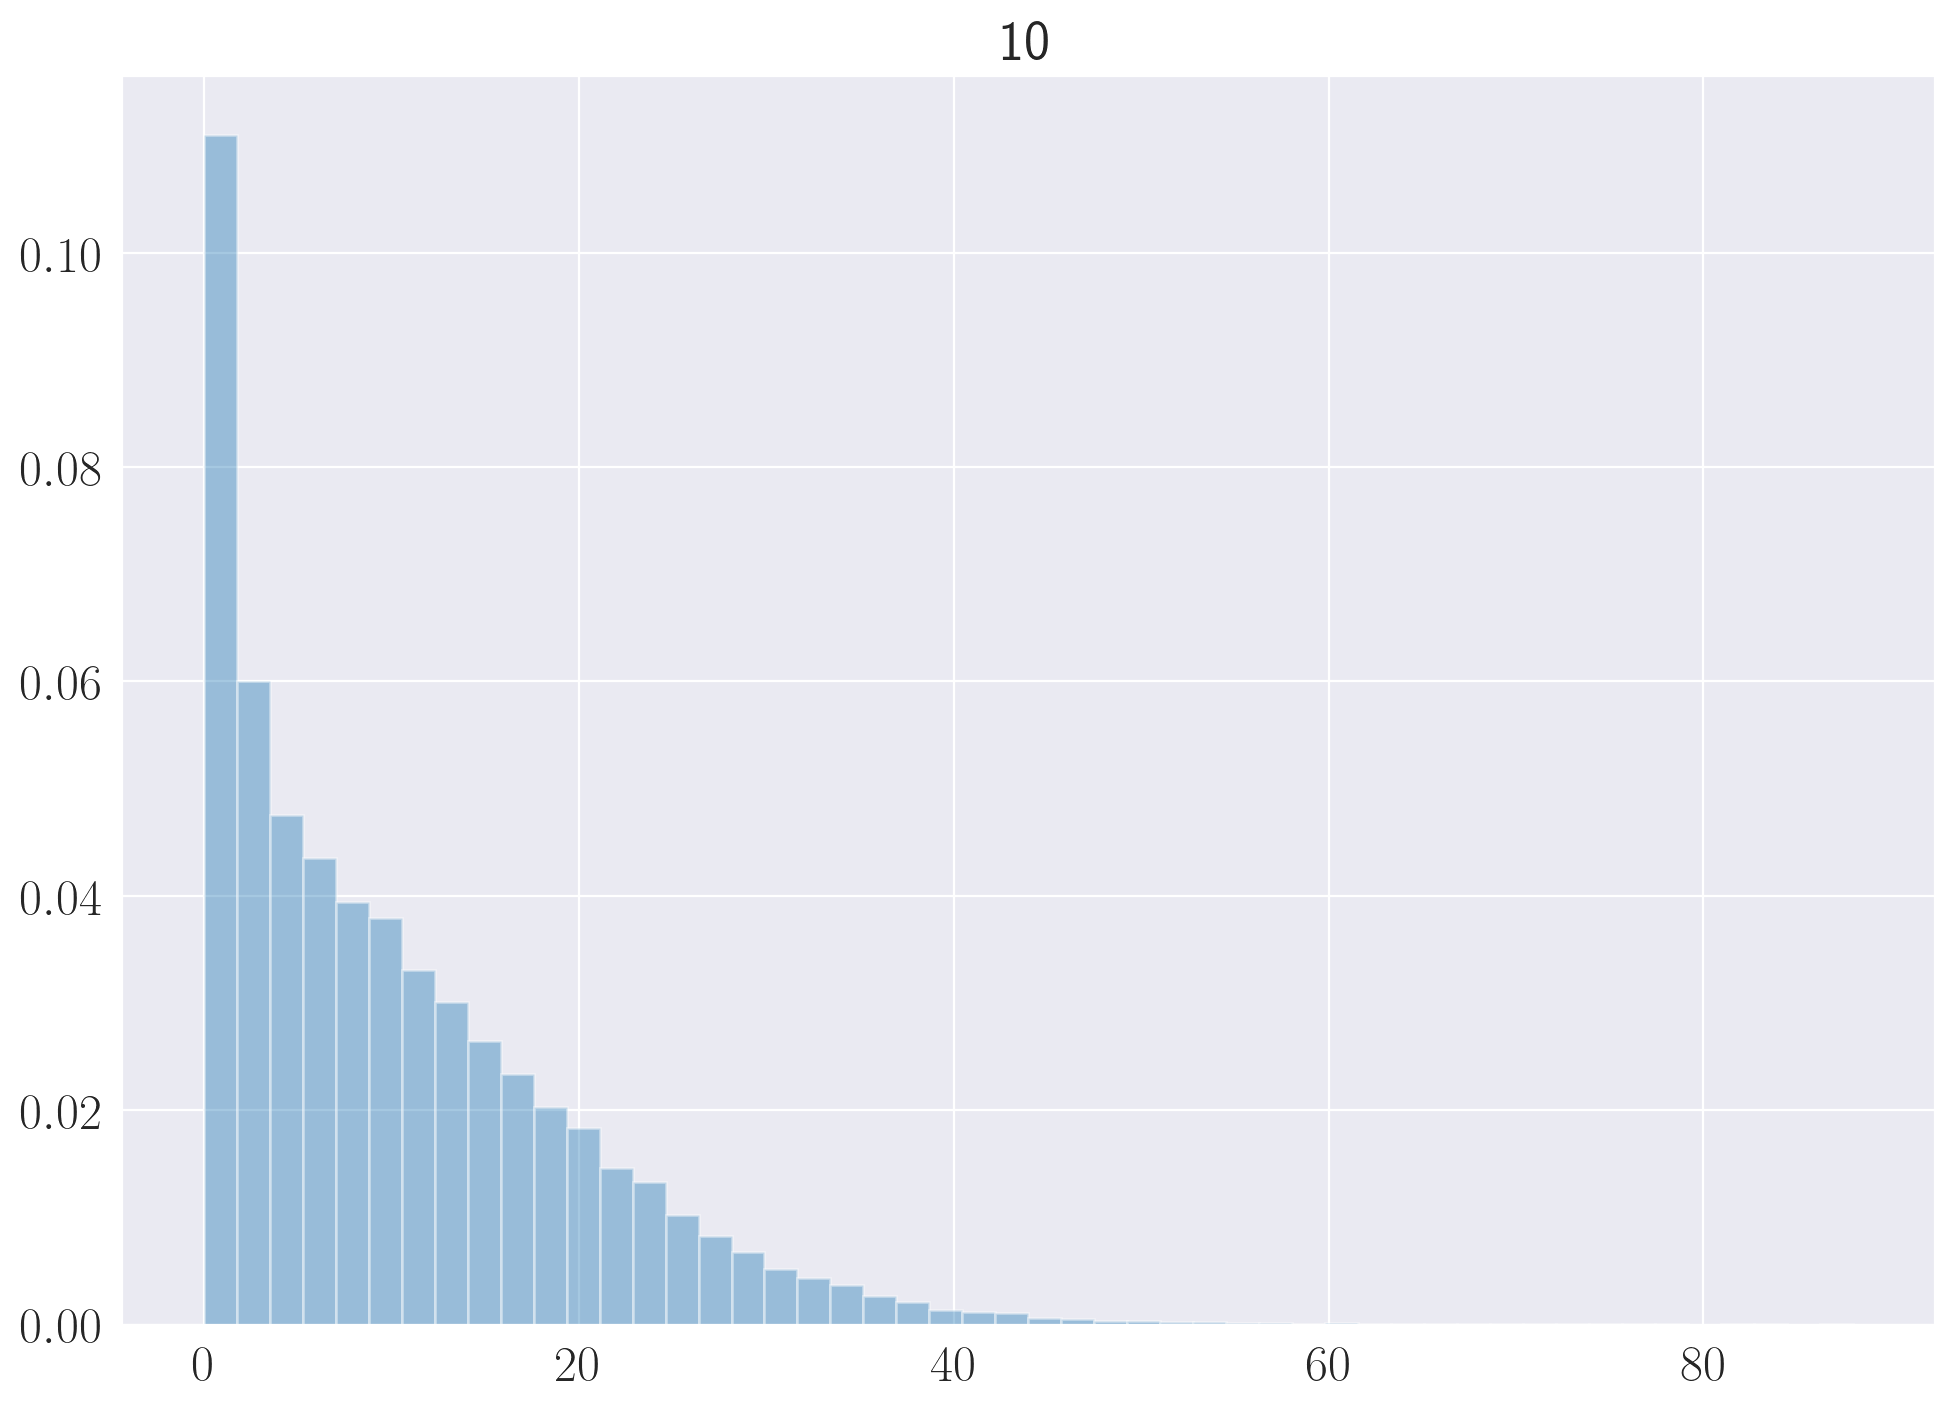

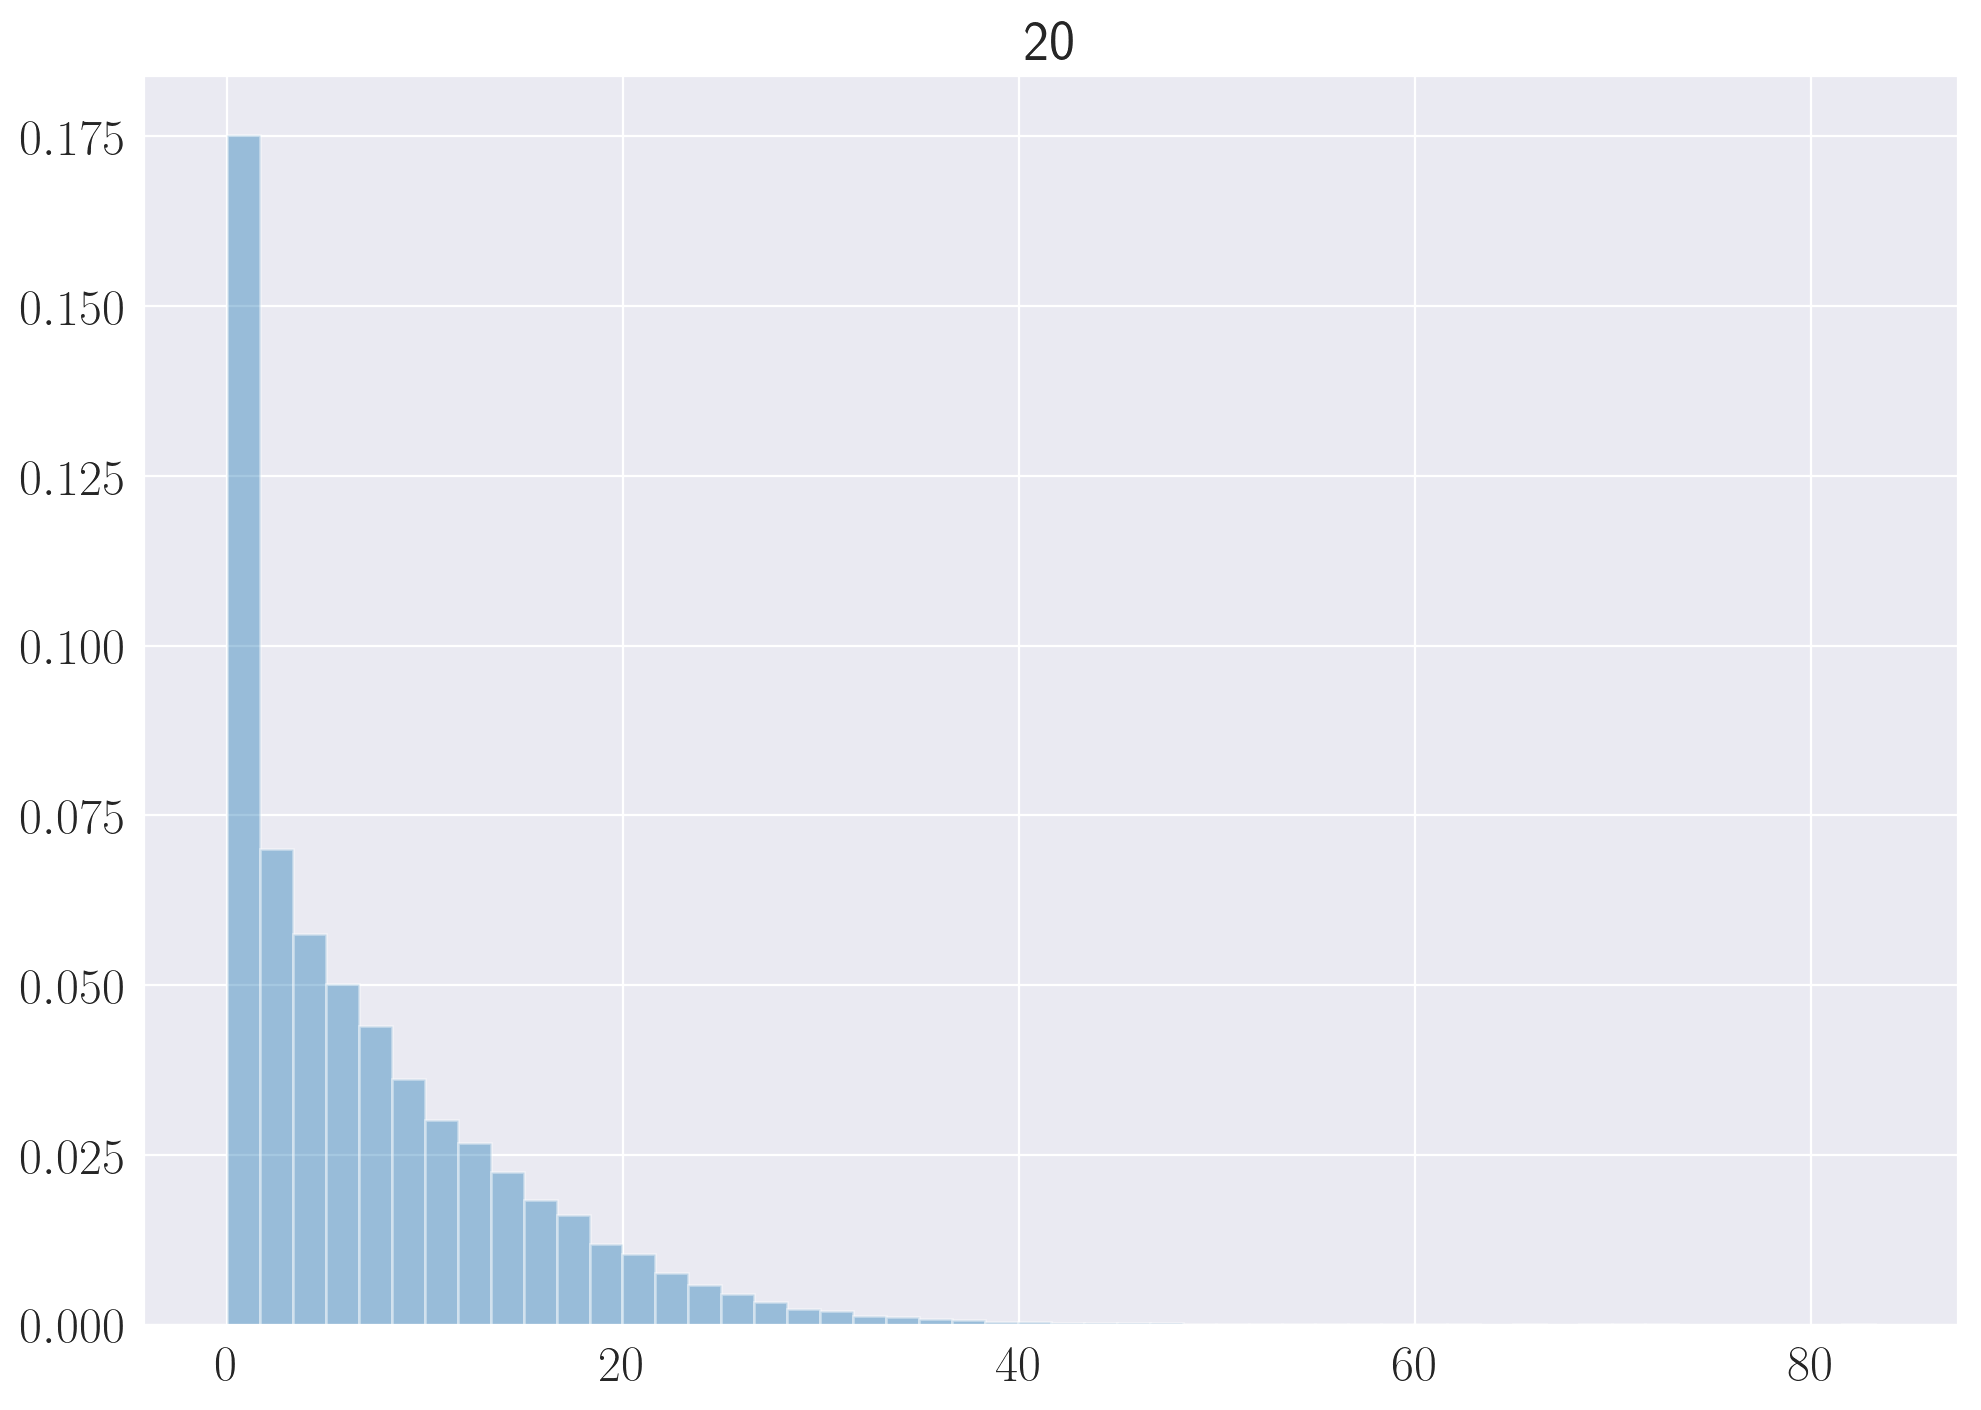

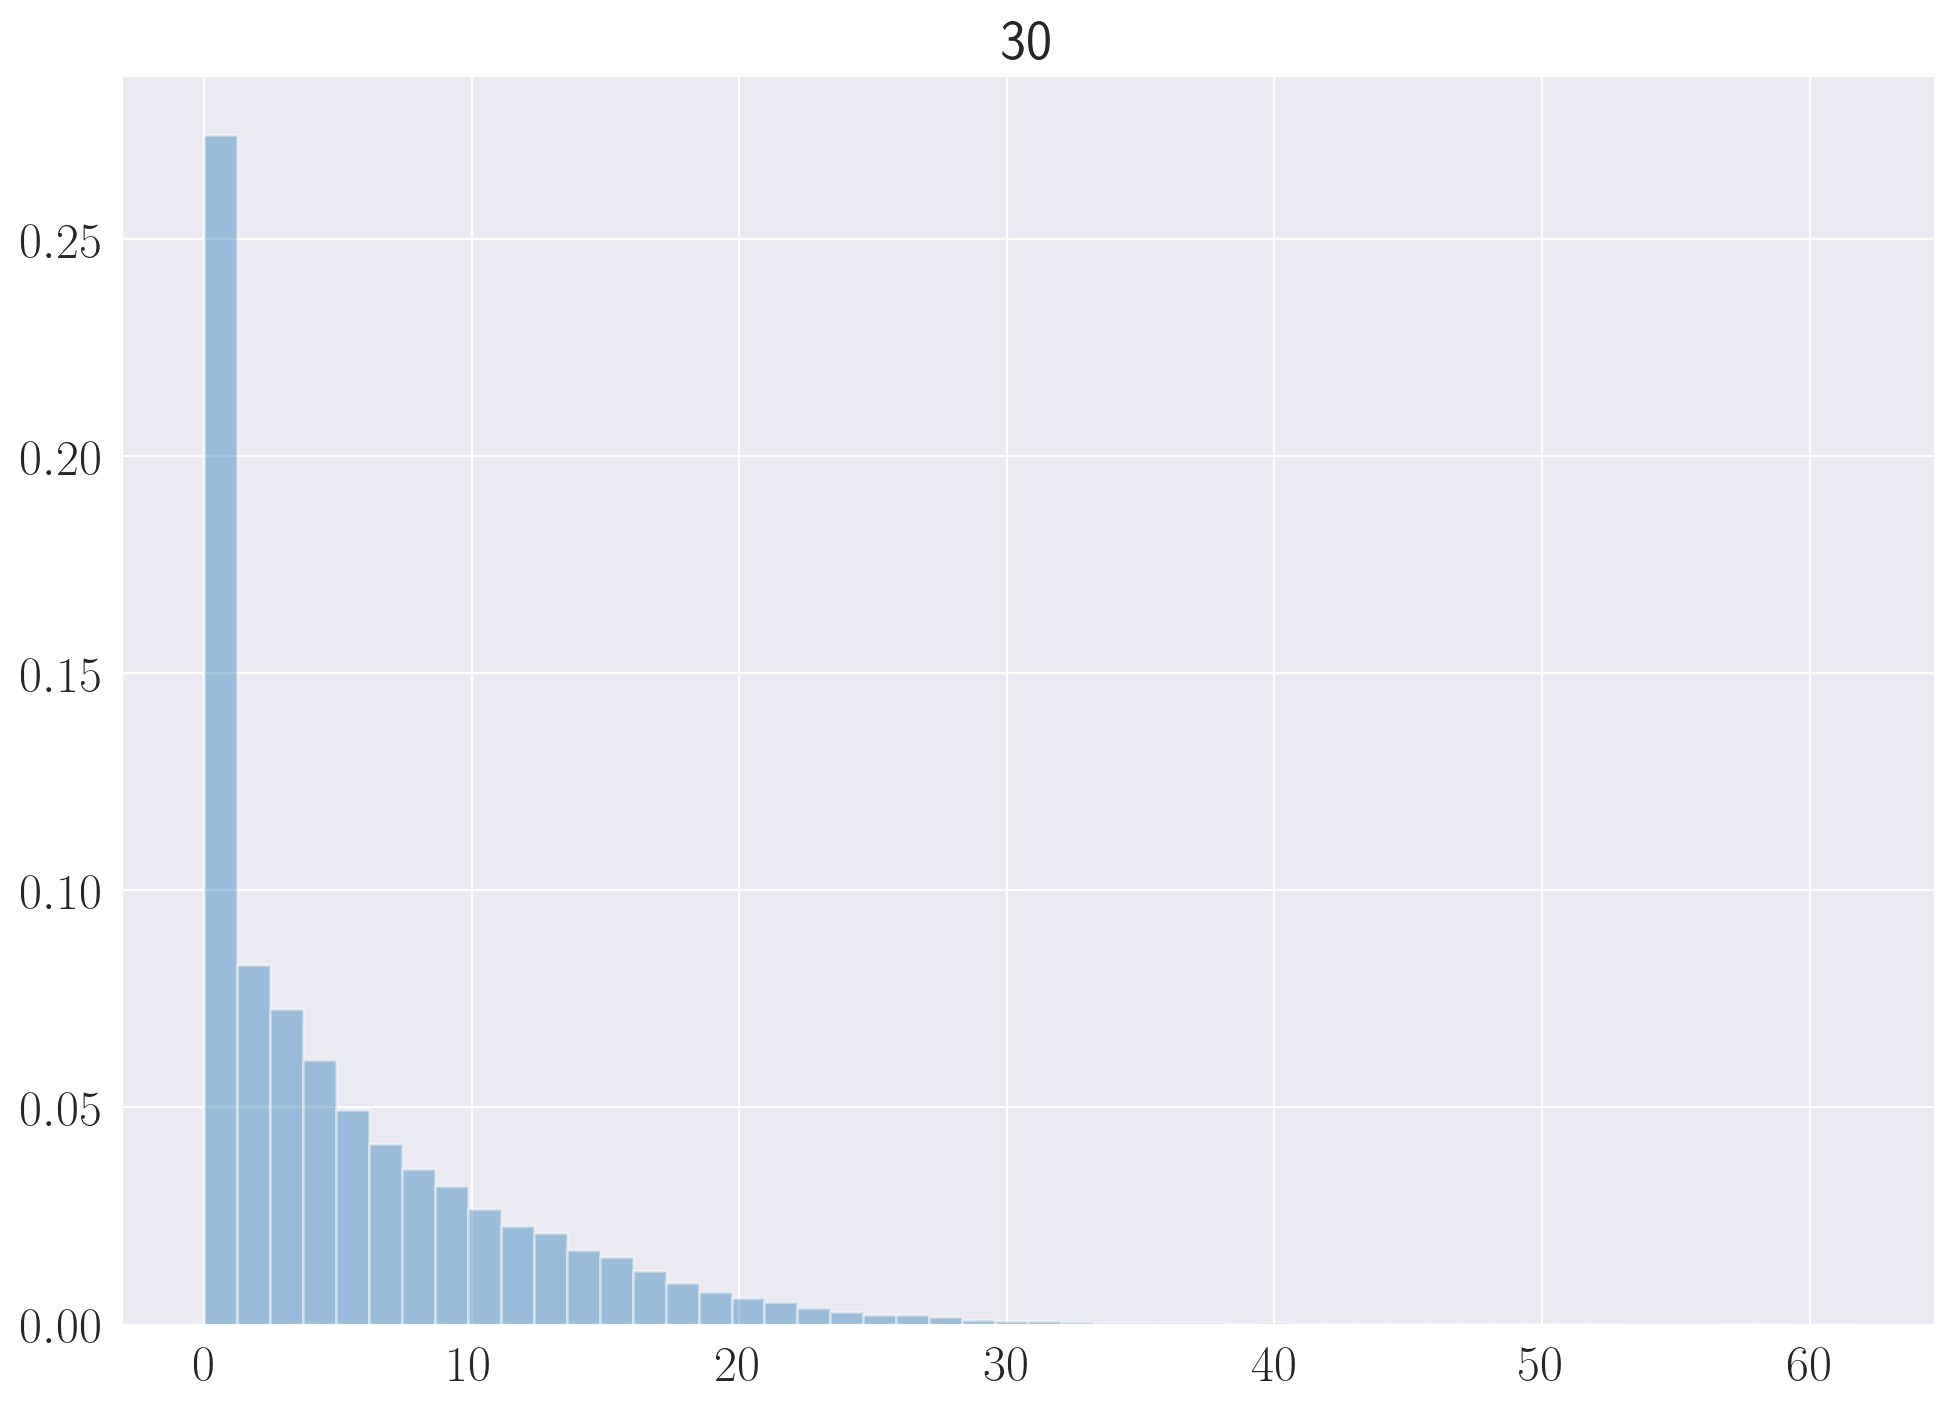

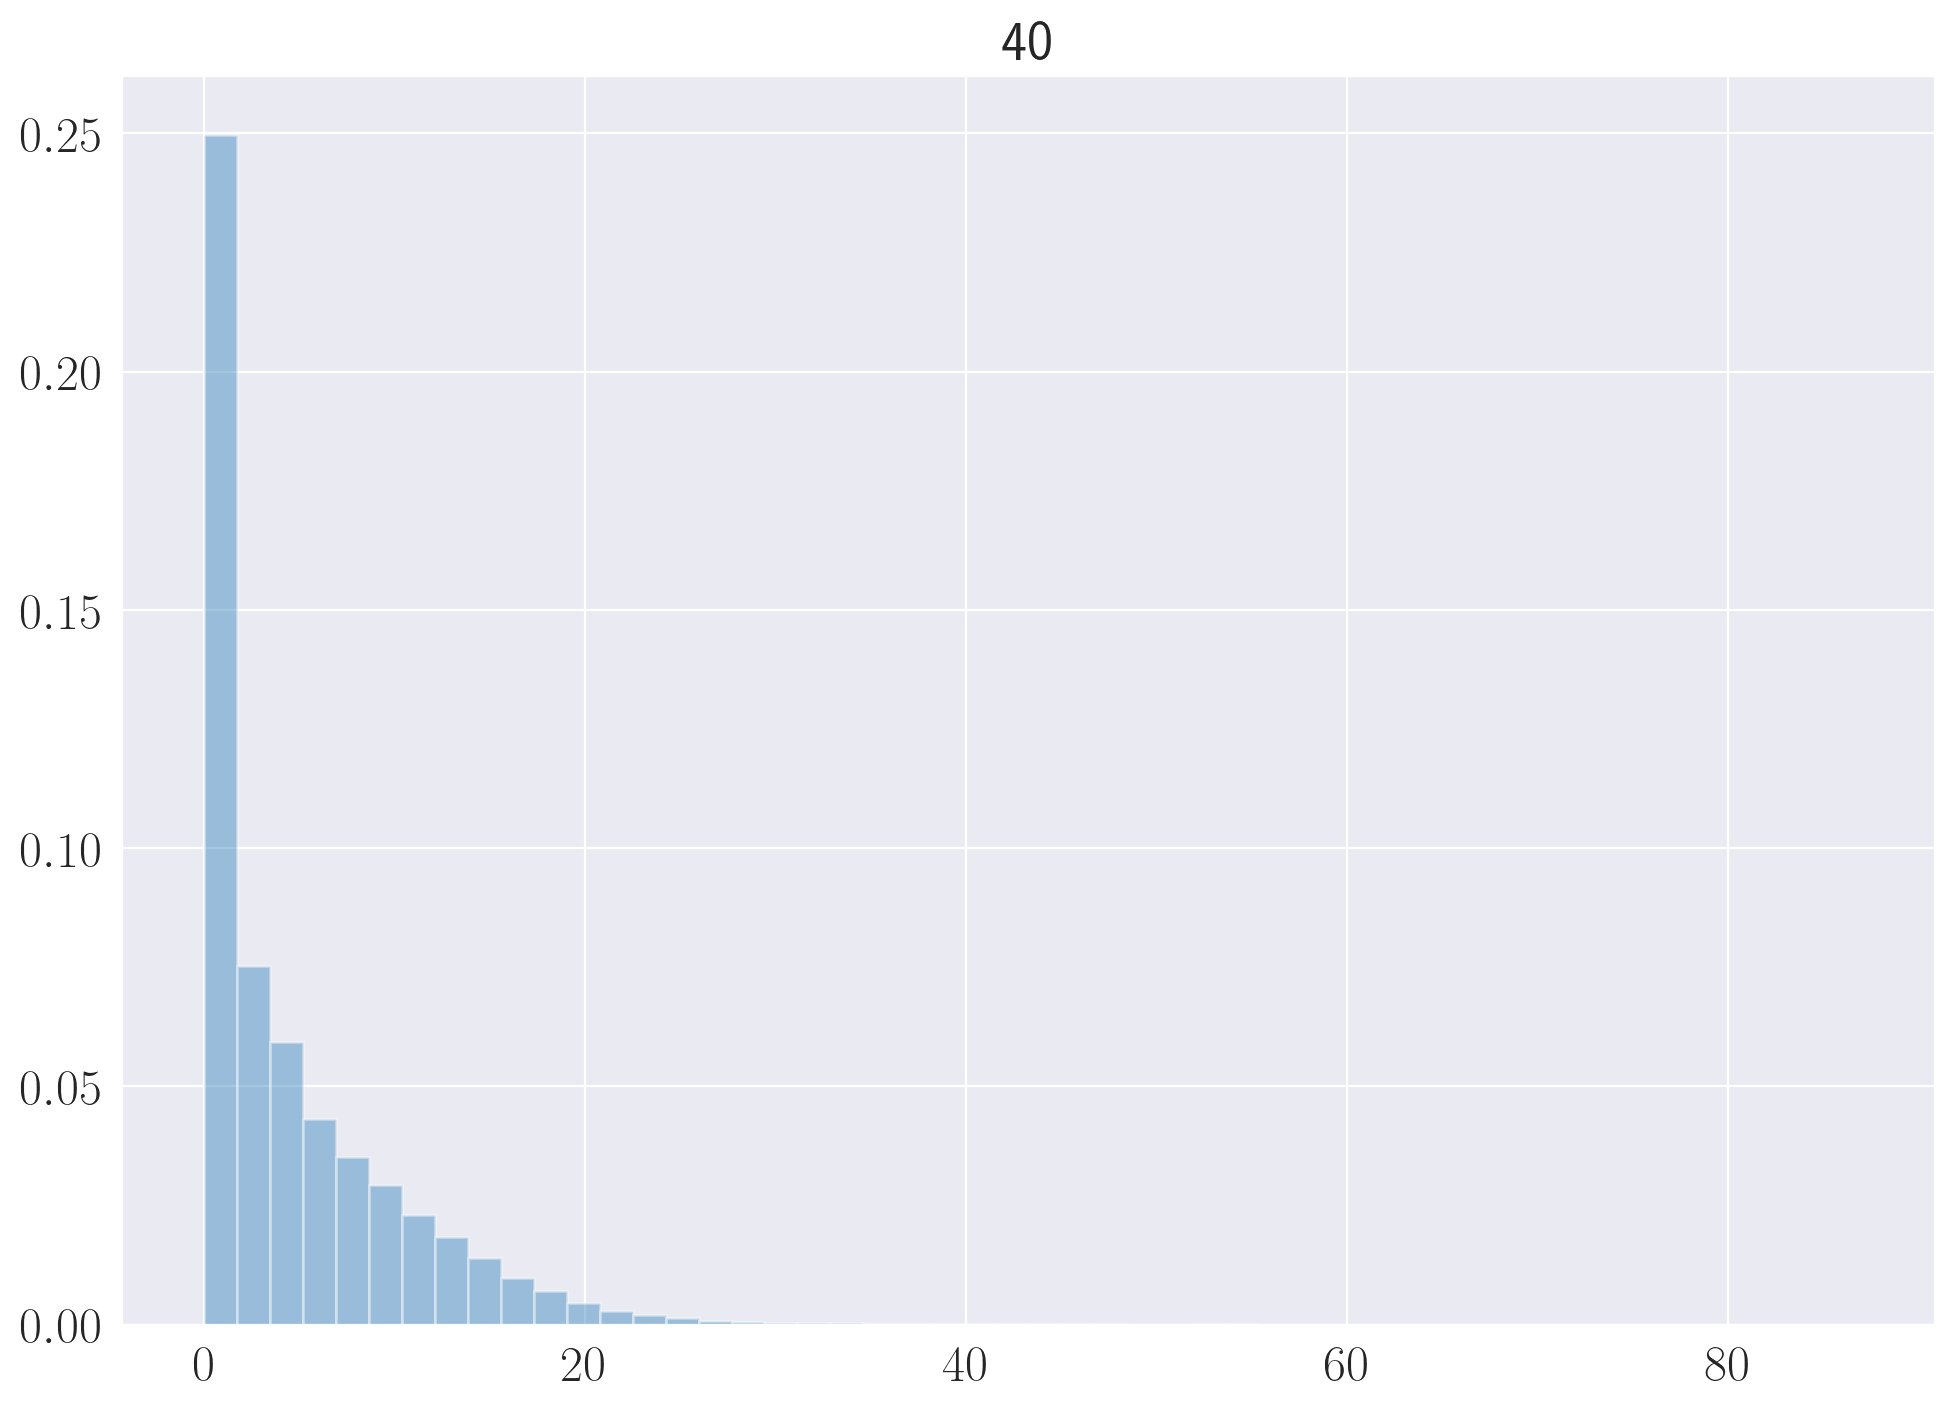

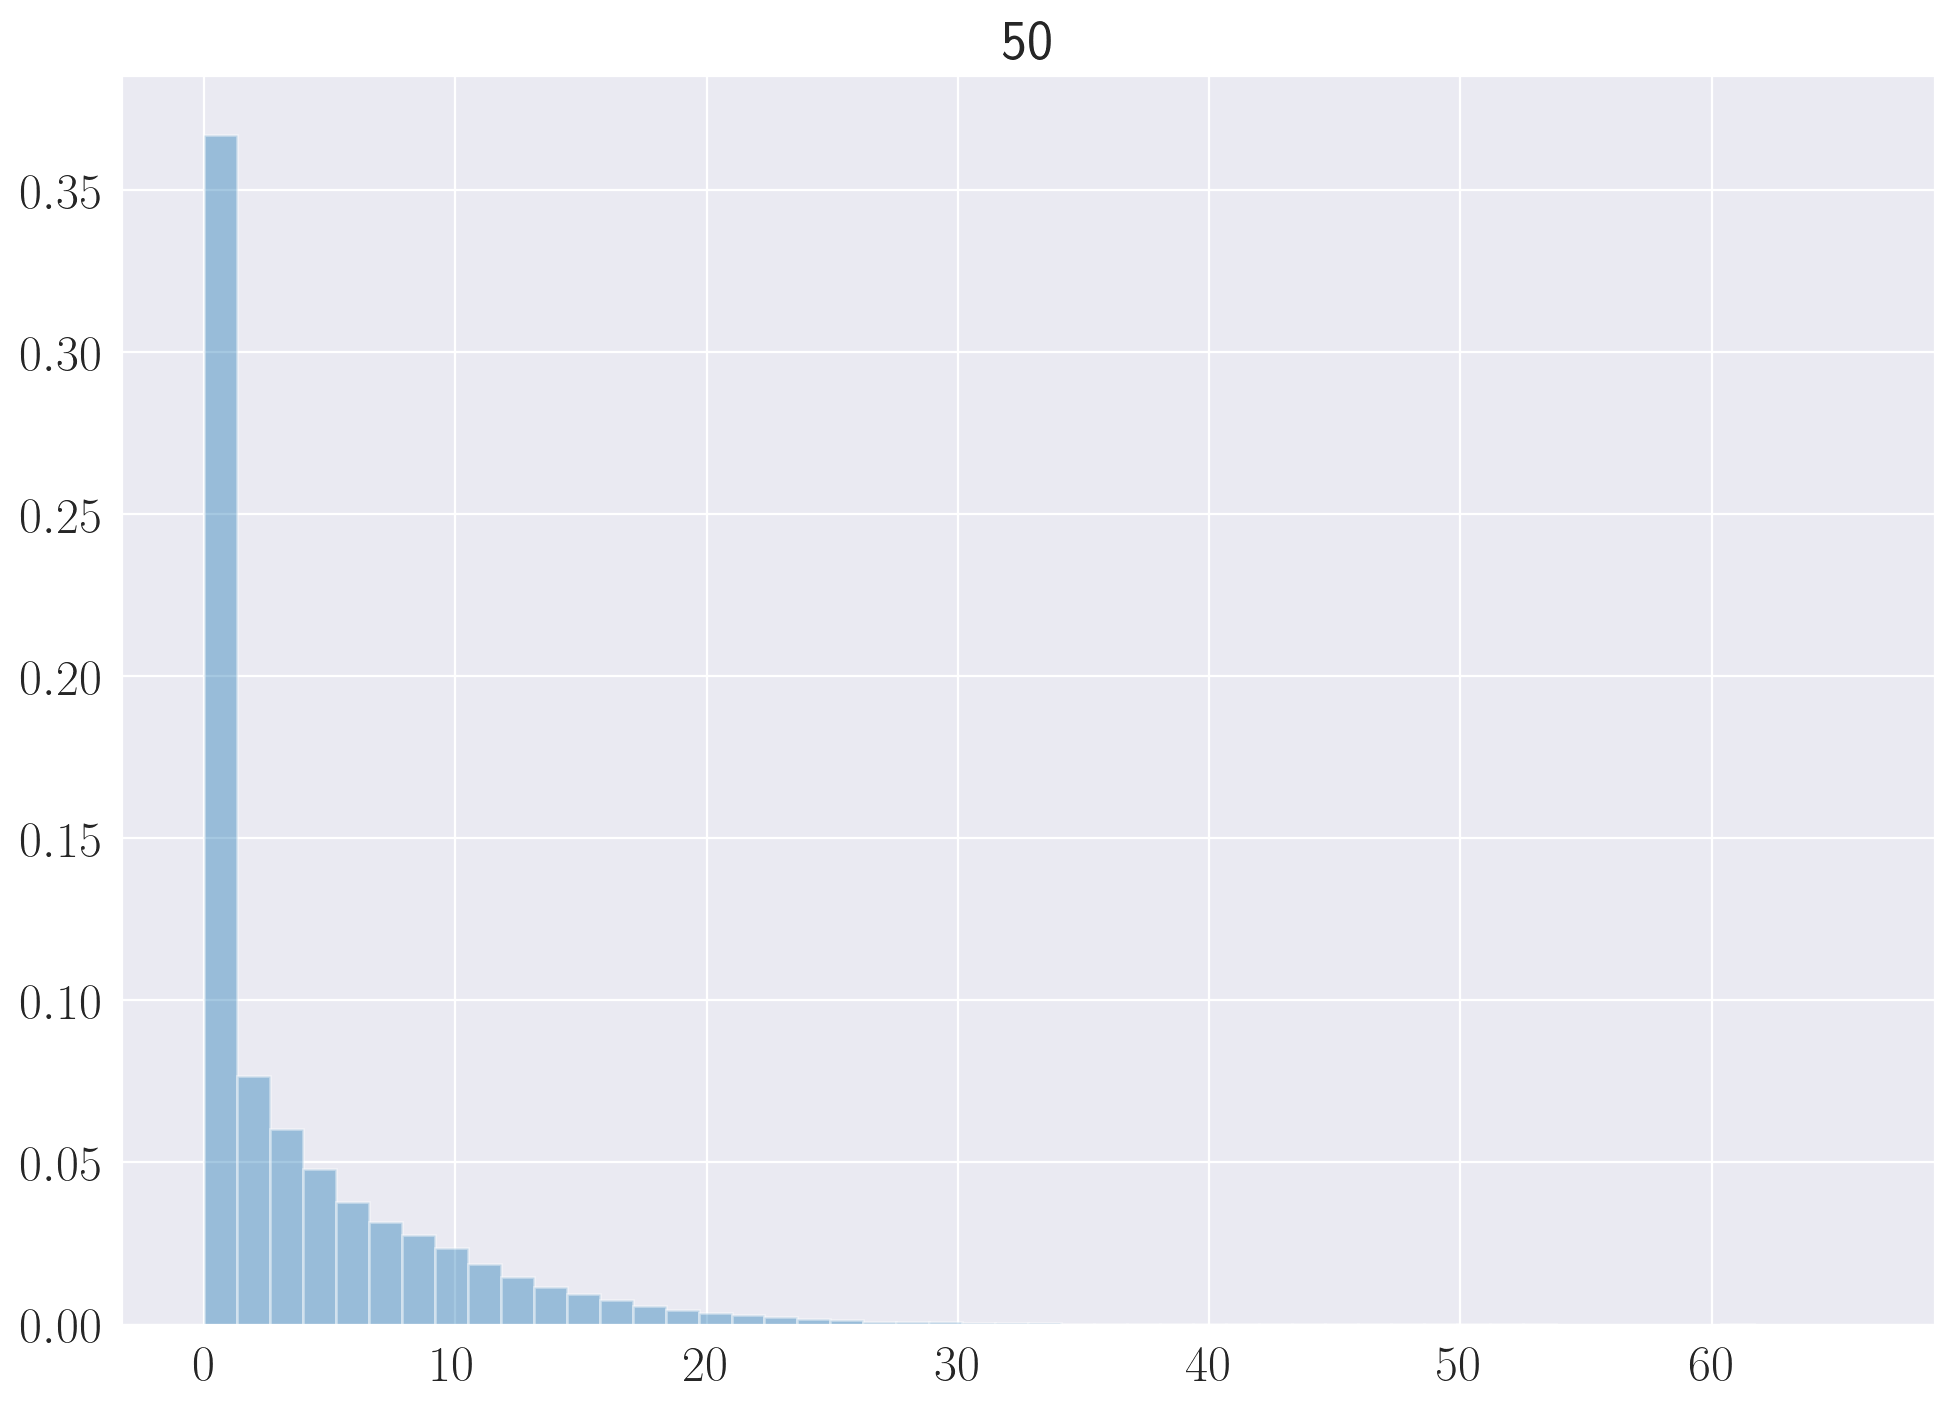

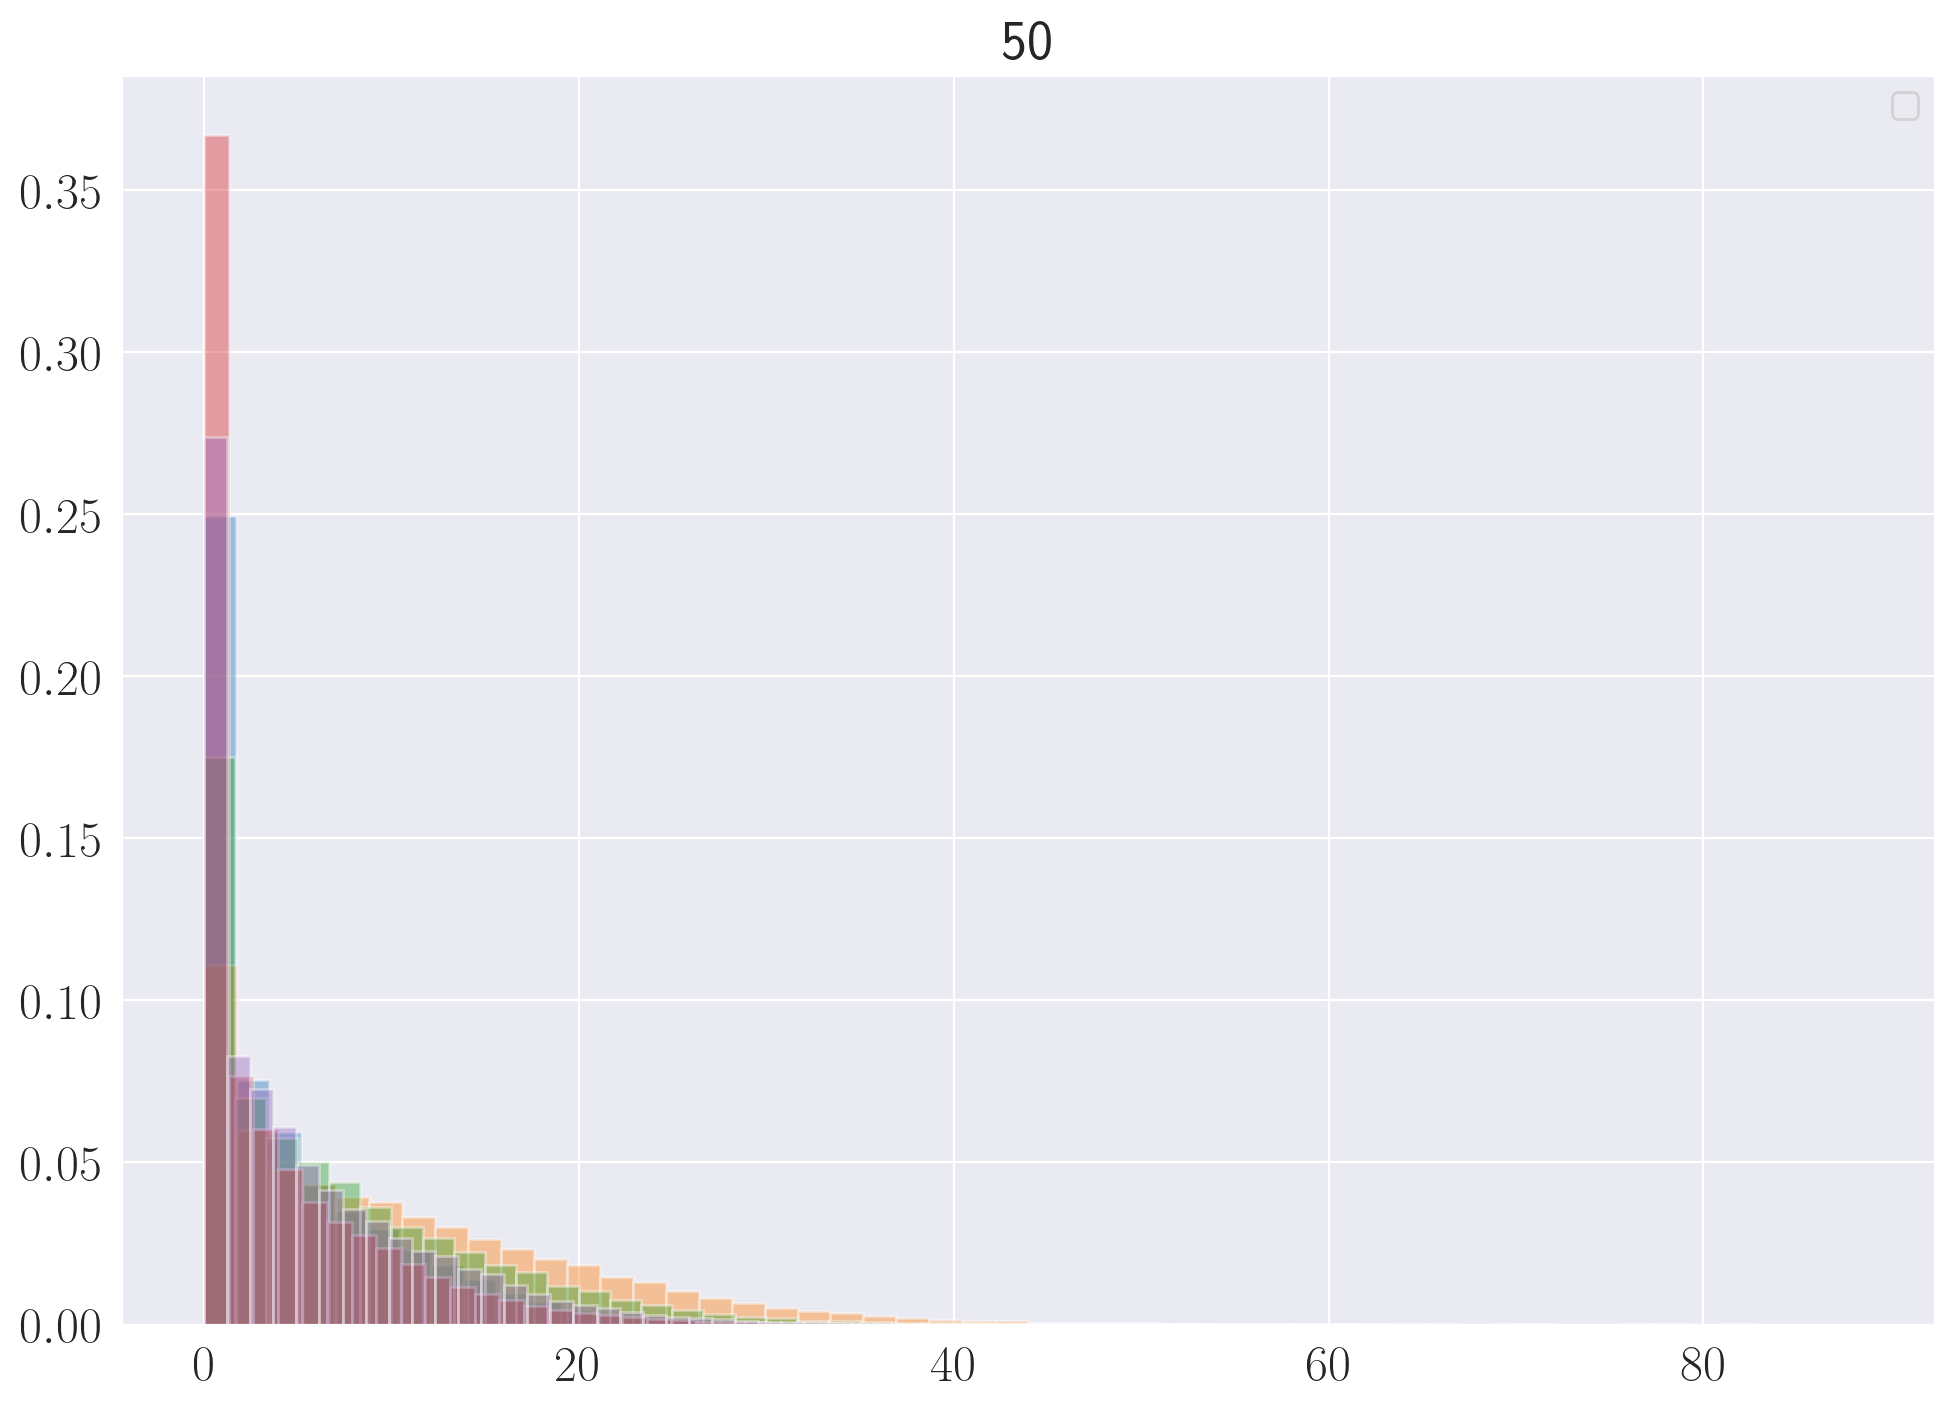

In [16]:
num_geometries = 3000
real_eigs = {}
for h11_temp in (10,20,30,40,50):
    files_list = [d for d in os.listdir('../../KS4/data') if "_"+str(h11_temp)+"_" in d and '_' in d and 'evals' in d]
    train_list = files_list[:num_geometries]
    test_list = [t for t in files_list if t not in train_list]
    
    
    cur_evals = []
    for test_file in test_list:
        cur_evals.extend(pickle.load(open('../../KS4/data/'+test_file,'r')))
    real_eigs[h11_temp] = cur_evals

    
for h11_temp in (10,20,30,40,50):
    print "h11, n_eigs:", h11_temp,len(real_eigs[h11_temp])
    
real_eig_dfs = {
                10: pd.DataFrame({10: real_eigs[10]})[10],
                20: pd.DataFrame({20: real_eigs[20]})[20],
                30: pd.DataFrame({30: real_eigs[30]})[30],
                40: pd.DataFrame({40: real_eigs[40]})[40],
                50: pd.DataFrame({50: real_eigs[50]})[50],
               }

histogram(real_eig_dfs[10], '')
histogram(real_eig_dfs[20], '')
histogram(real_eig_dfs[30], '')
histogram(real_eig_dfs[40], '40')
histogram(real_eig_dfs[50], '50')

histograms([real_eig_dfs[k] for k in real_eig_dfs], ['10','20','30','40','50'], log10=True)

histogram(real_eig_dfs[10], '10', log10=False)
histogram(real_eig_dfs[20], '20', log10=False)
histogram(real_eig_dfs[30], '30', log10=False)
histogram(real_eig_dfs[40], '40', log10=False)
histogram(real_eig_dfs[50], '50', log10=False)

histograms([real_eig_dfs[k] for k in real_eig_dfs], ['10','20','30','40','50'], log10=False)

# Training

In [15]:
from torch.autograd import Variable

def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [16]:
GAN_list = []

try:
    for epoch in range(N_EPOCHS + 1):
        for batch_number, data in enumerate(data_loader):
    
            images = data[0]
            batch_size = images.shape[0] # b/c could be < batchSize for last batch
            
            images = to_var(images.view(batch_size,-1))
            
            ###
            # TRAIN DISCRIMINATOR
            ###
            
            # Create discriminator targets
            real_labels = to_var(torch.ones(batch_size,1))
            fake_labels = to_var(torch.zeros(batch_size,1))
            
            # Pass through discriminator, record score, compute loss
            outputs = D(images)
            real_score = outputs
            d_loss_real = criterion(outputs,real_labels)
            
            # Generate images from noise
            z = to_var(torch.randn(batch_size,nz))
            fake_images = G(z)
            
            # Evaluate discriminator on fake images, record score, compute loss
            outputs = D(fake_images)
            fake_score = outputs
            d_loss_fake = criterion(outputs, fake_labels)
            
            # Backprop and optimize discriminator
            d_loss = d_loss_real + d_loss_fake # total loss is sum of parts
            D.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            ###
            # TRAIN GENERATOR
            ###
            
            for g_epoch in range(G_EPOCHS):
                # Generate images from noise
                z = to_var(torch.randn(batch_size,nz))
                fake_images = G(z)
                outputs = D(fake_images)

                # Compute G loss: G does well if D thinks fake is real
                g_loss = criterion(outputs,real_labels)

                # Backprop and optimize generator
                D.zero_grad()
                G.zero_grad()
                g_loss.backward()
                g_optimizer.step()
            
        ###
        # Print progress as training occurs
        ###

        if (epoch) % 5 == 0:
            GAN_list.append((h11,epoch,copy.deepcopy(G).cpu()))
            print('Epoch [%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    N_EPOCHS,
                    d_loss.data,
                    g_loss.data,
                    real_score.data.mean(),
                    fake_score.data.mean())
            )
    
except KeyboardInterrupt:
    print("Training ended via keyboard interrupt.")

Epoch [0/100], d_loss: 4.2241, g_loss: 0.0755, Mean D(x): 0.54, Mean D(G(z)): 0.96
Epoch [5/100], d_loss: 1.5797, g_loss: 0.7209, Mean D(x): 0.40, Mean D(G(z)): 0.49
Epoch [10/100], d_loss: 1.4306, g_loss: 0.7796, Mean D(x): 0.44, Mean D(G(z)): 0.46
Training ended via keyboard interrupt.


(h11, epoch): (50, 0)


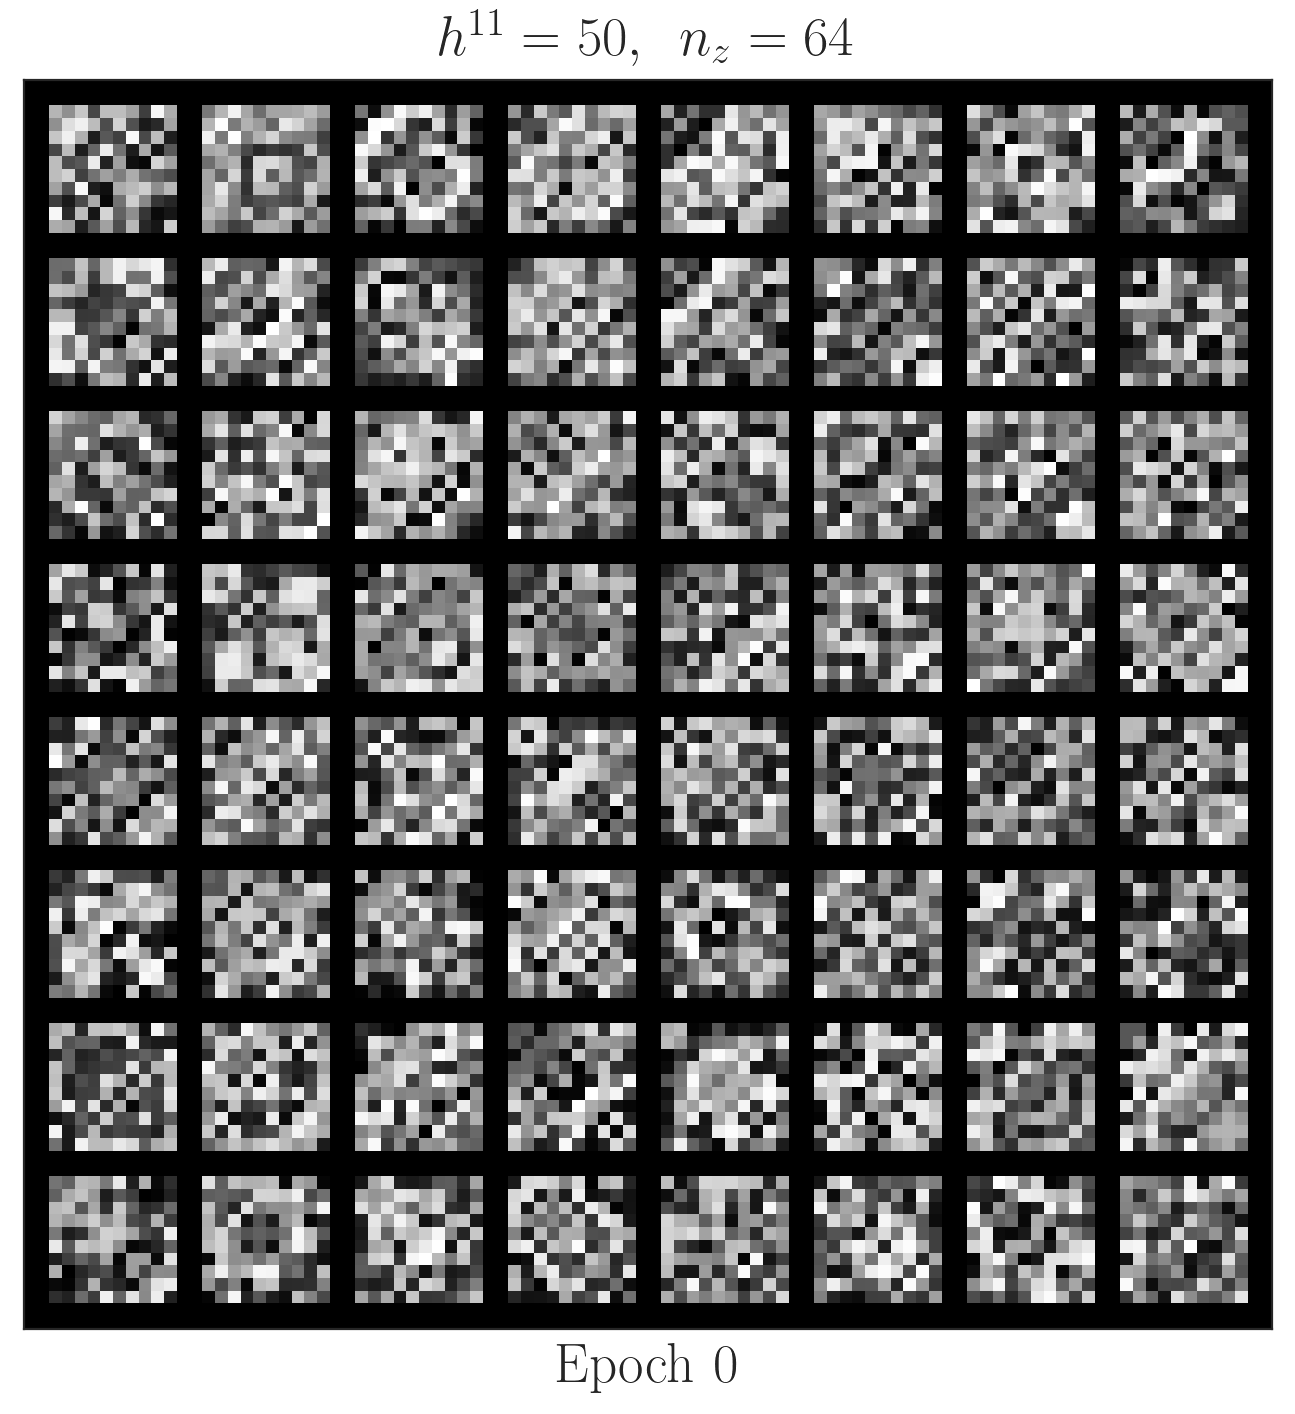

(h11, epoch): (50, 5)


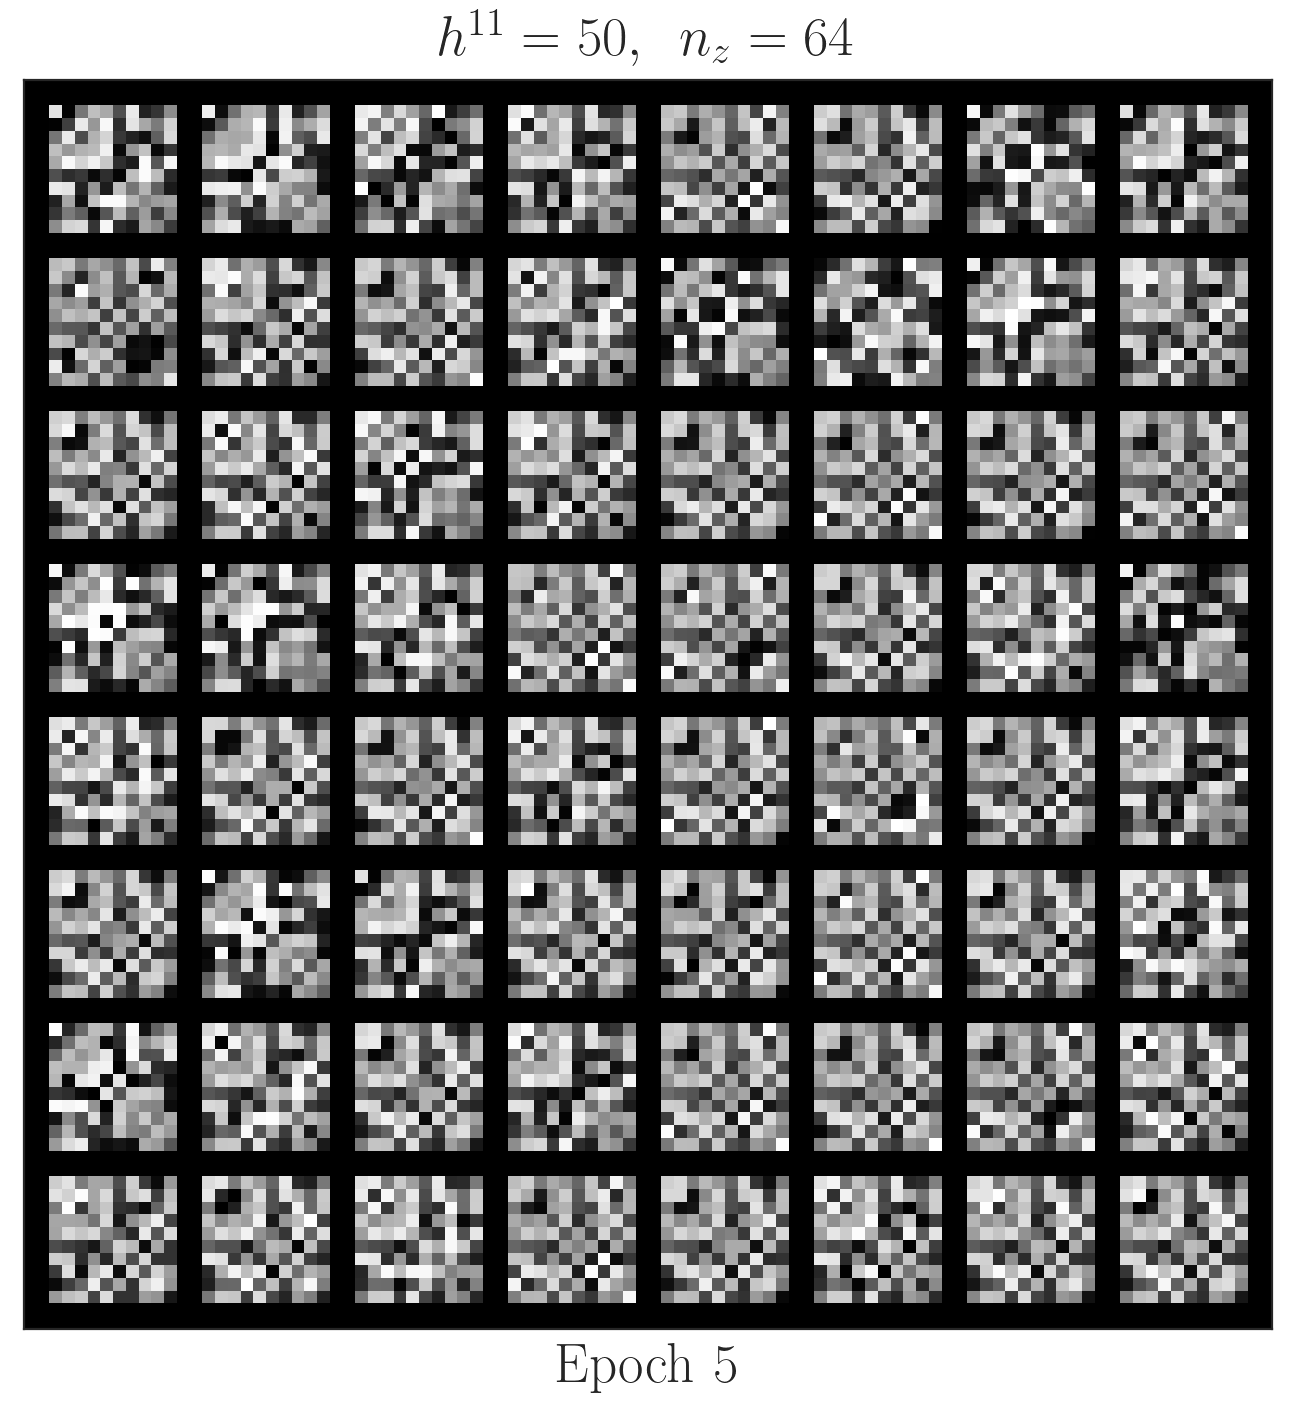

(h11, epoch): (50, 10)


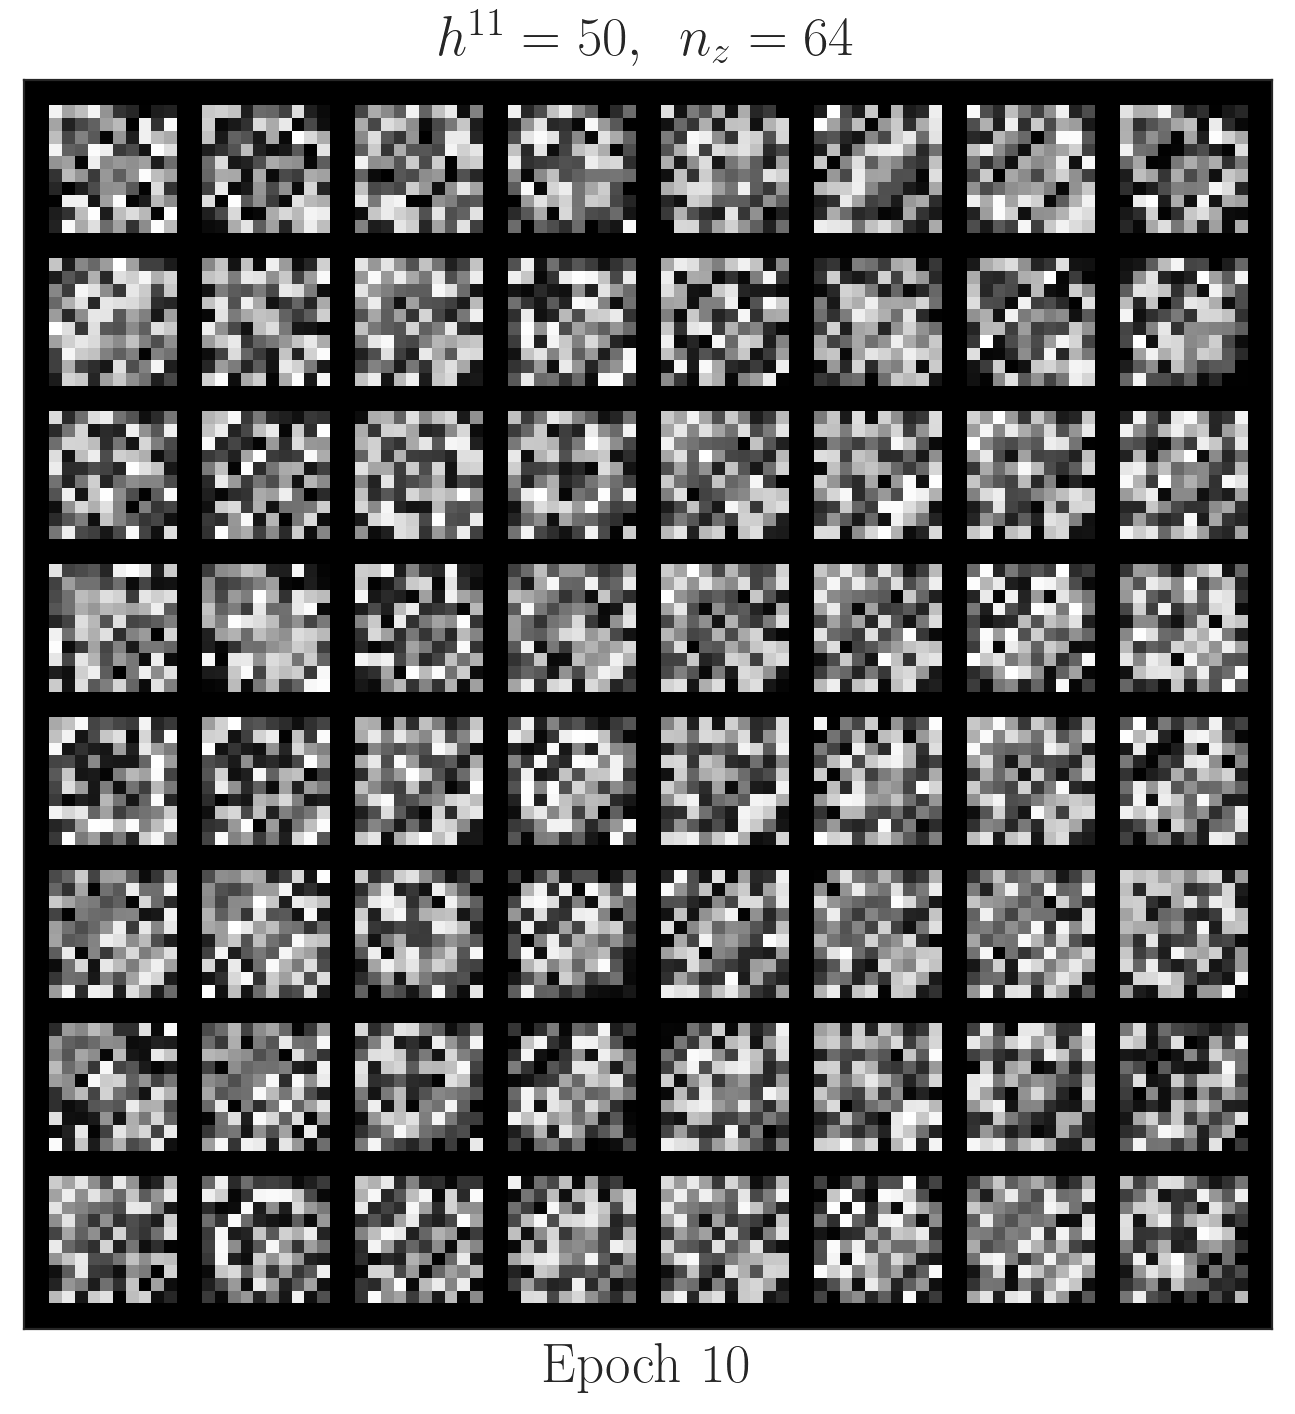

In [17]:
show_GAN_image_sequence(GAN_list, batchSize = batchSize, nz = nz, scale_factor = 1, dpi = 500)

epoch: 0


/home/jim/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


(1.1920513209364554, 1.1920513209364554)


/home/jim/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


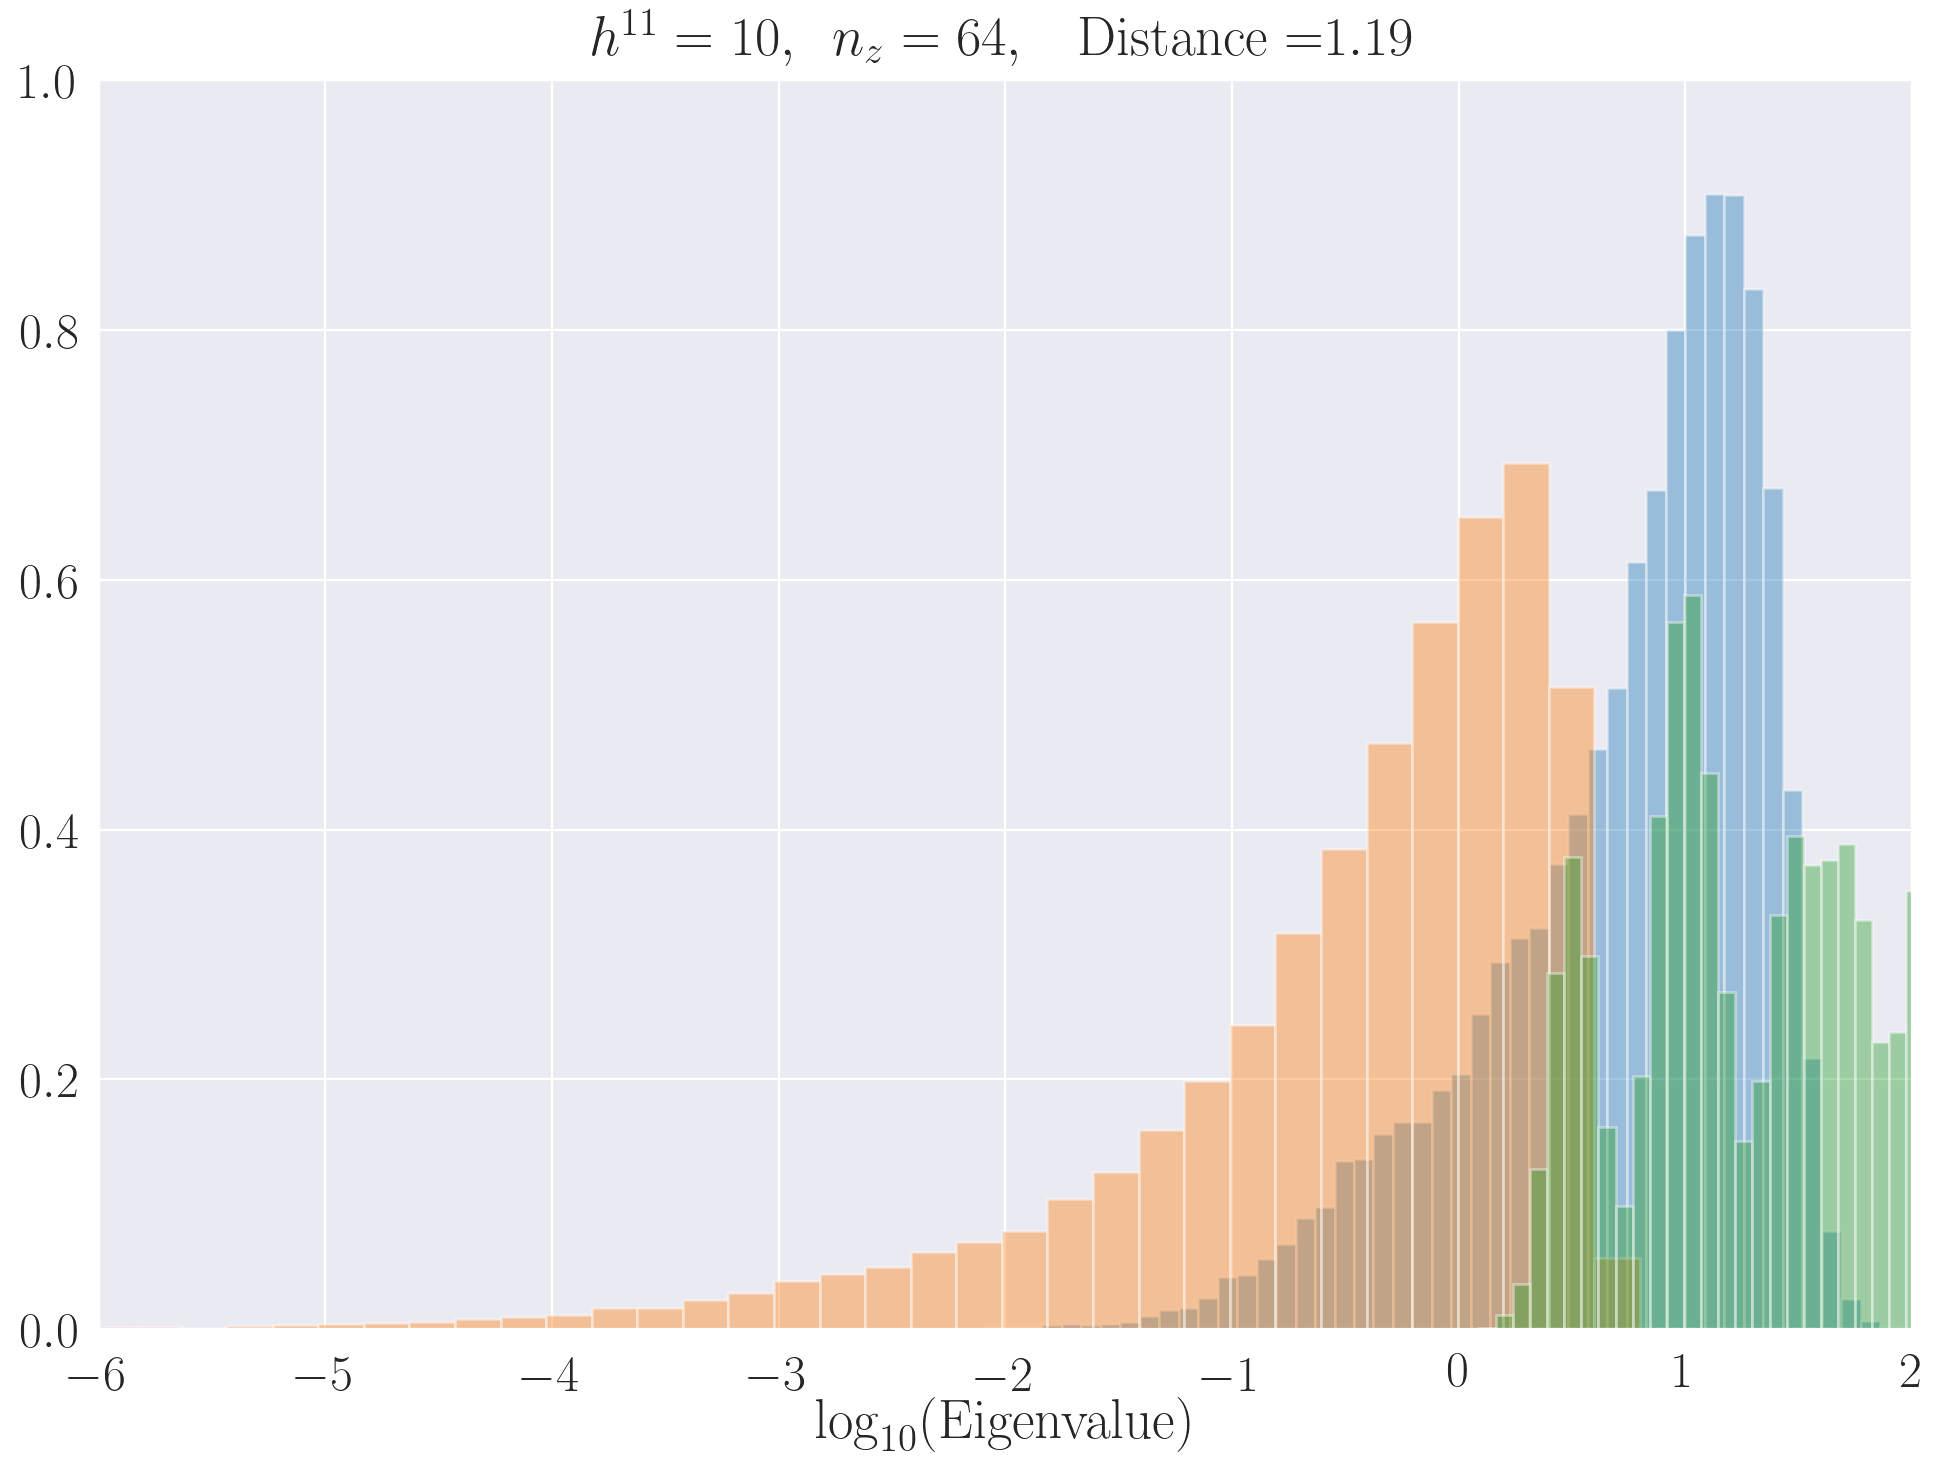

epoch: 5
(nan, nan)


KeyboardInterrupt: 

In [18]:
plt.clf()
for h11, epoch, netG in GAN_list:
    print 'epoch:', epoch
    show_GAN_histogram(netG, 10, 
                       batchSize = 6282, nz=nz, log10=True, dpi=300, display_wishart = True, ylim = (0,1), xlim = (-6,2))

# Wasserstein GAN

In [31]:
# Critic
# Note: just linear output


# Generator 
class symmetric_G(nn.Module):
    def __init__(self,nz,h11):
        super(symmetric_G, self).__init__()
        self.h11 = h11
        self.nz = nz
        self.fc1, self.fc2, self.fc3, self.fc4, self.fc5 = nn.Linear(nz, 256), nn.Linear(256, 256), nn.Linear(256, 256), nn.Linear(256, 256), nn.Linear(256, self.h11*self.h11)
        self.a1, self.a2, self.a3, self.a4 = nn.LeakyReLU(0.2), nn.LeakyReLU(0.2), nn.LeakyReLU(0.2), nn.LeakyReLU(0.2)
        
    def forward(self,input):
        o1 = self.a1(self.fc1(input))
        o2 = self.a1(self.fc2(o1))
        o3 = self.a1(self.fc3(o2))
        o4 = self.a1(self.fc4(o3))
        o5 = self.fc5(o4)
        o, oT, s = o5.view(o5.shape[0],self.h11,self.h11), torch.transpose(o5.view(o5.shape[0],self.h11,self.h11),1,2), o5.shape
        m = torch.bmm(o,oT)
        return m.view(m.shape[0],self.h11*self.h11)
    
generator = symmetric_G(nz,h11)
# G = nn.Sequential(
#     nn.Linear(nz, 256),
#     nn.LeakyReLU(0.2),
#     nn.Linear(256, 256),
#     nn.LeakyReLU(0.2),
#     nn.Linear(256, 256),
#     nn.LeakyReLU(0.2),
#     nn.Linear(256, 256),
#     nn.LeakyReLU(0.2),
#     nn.Linear(256, h11 * h11),
# )

# if you're running on GPU, move models there
if torch.cuda.is_available():
    critic.cuda()
    generator.cuda()

In [32]:
# WGAN Defaults
LR = 0.00005
N_EPOCHS = 10000
N_CRITIC_STEPS = 5
CLAMP = 0.01

In [33]:
critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LR)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LR)

For WGAN, we will do N_CRITIC steps for a single generator update, because the whole point of WGAN is to use a loss from a well-trained critic

In [34]:
from torch.autograd import Variable
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

Epoch [0/10000], d_loss: -1.6894, g_loss: -0.1761, Mean D(x): 1.93, Mean D(G(z)): 0.24


/Users/jim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


(1.0654734480453187, 1.0654734480453187)


/Users/jim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


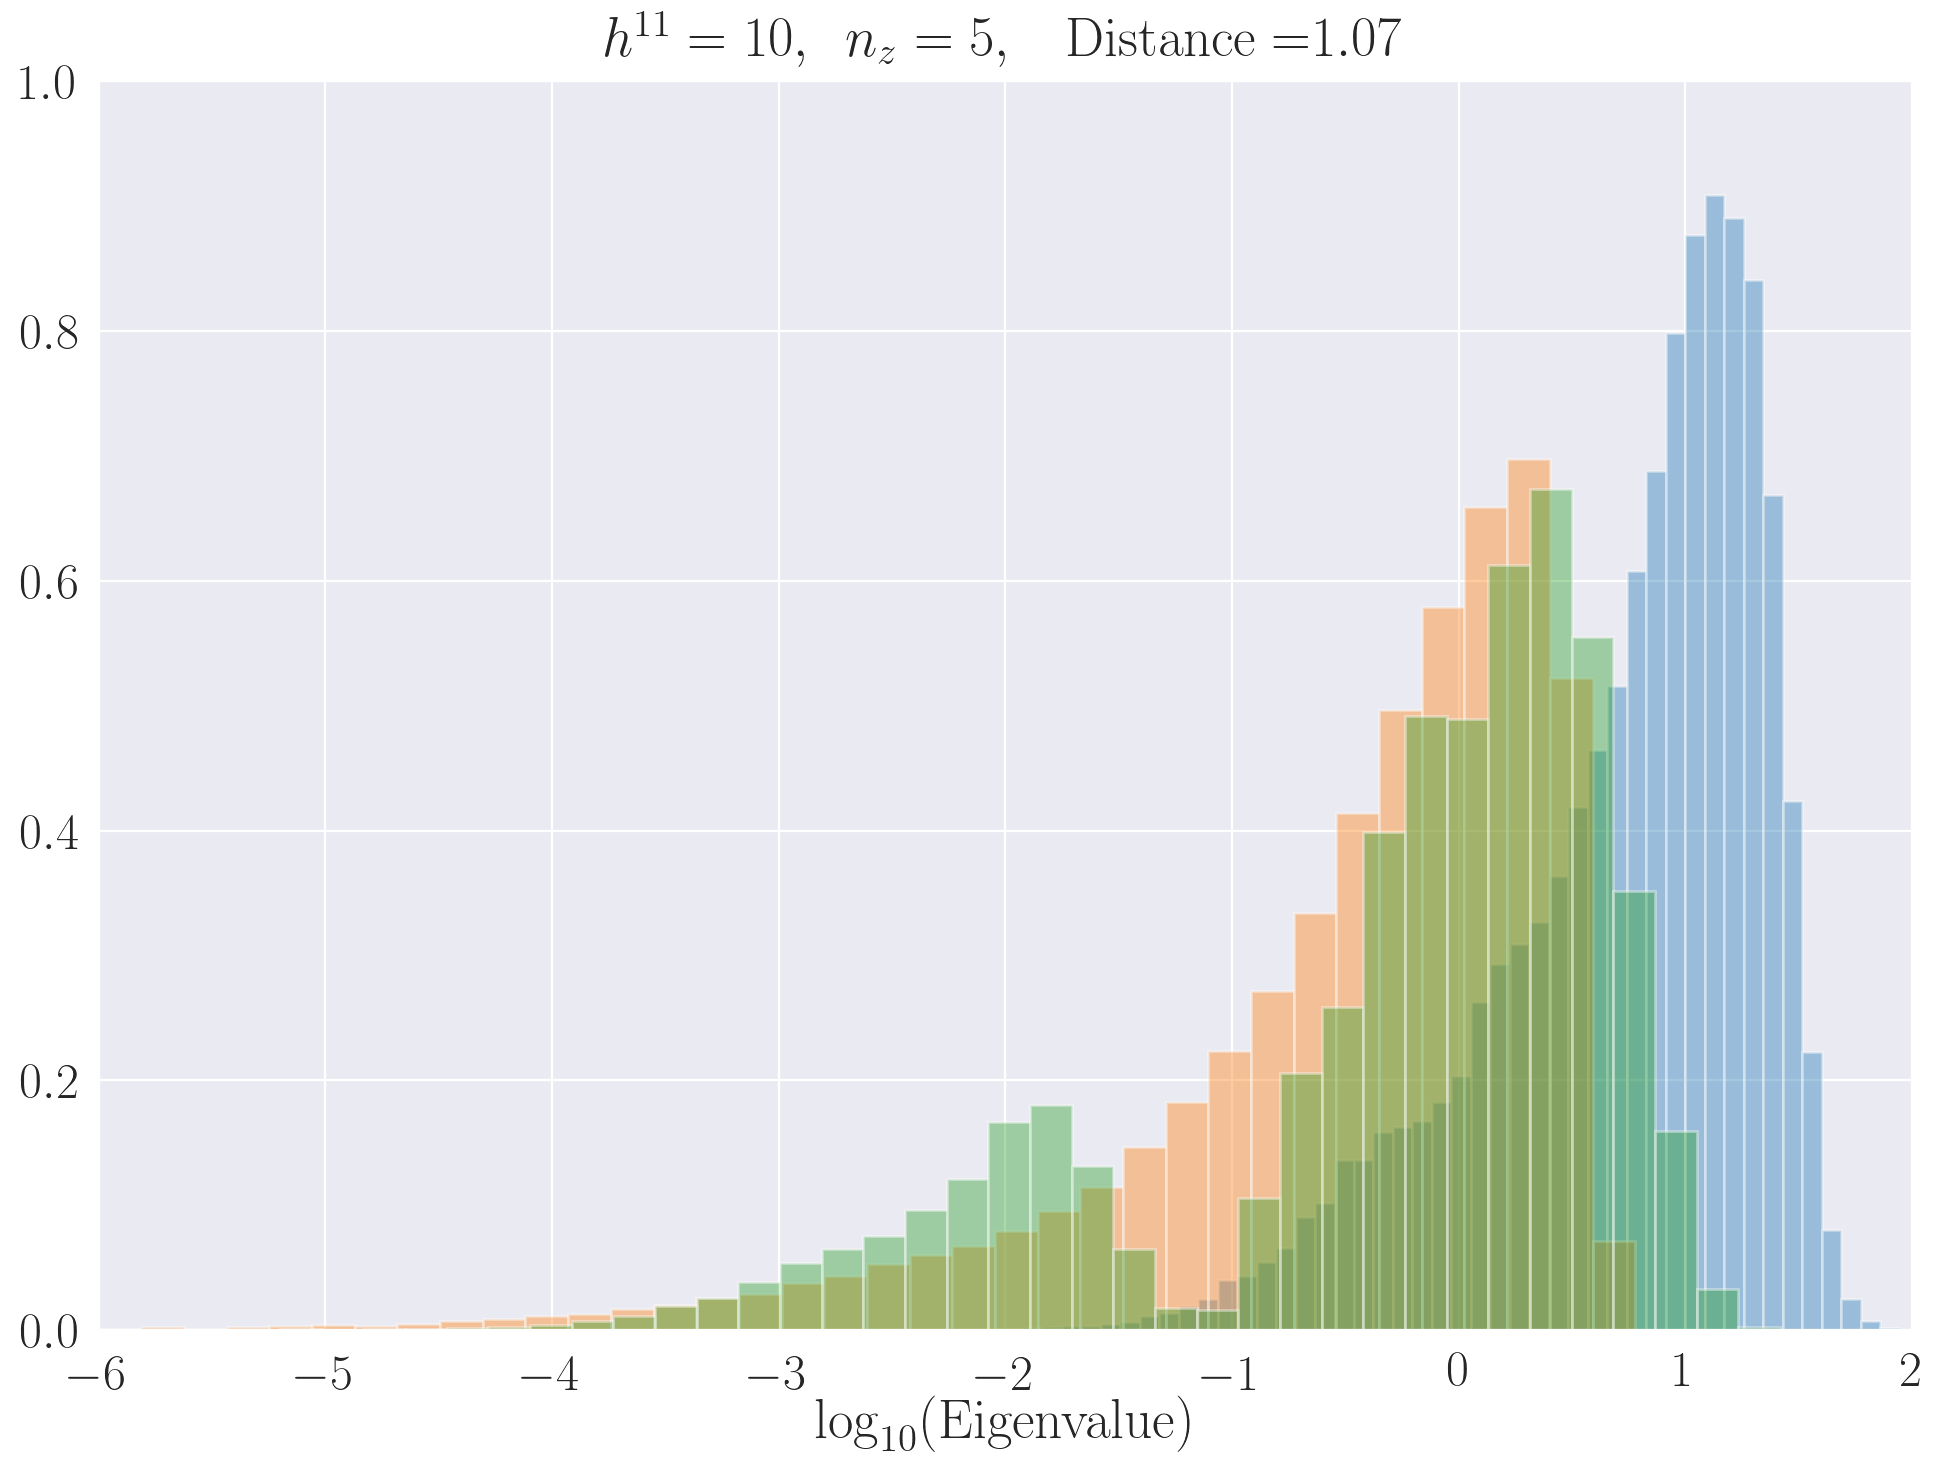

Epoch [20/10000], d_loss: -0.3917, g_loss: -0.4795, Mean D(x): 0.96, Mean D(G(z)): 0.56
(0.26437030743946854, 0.26437030743946854)


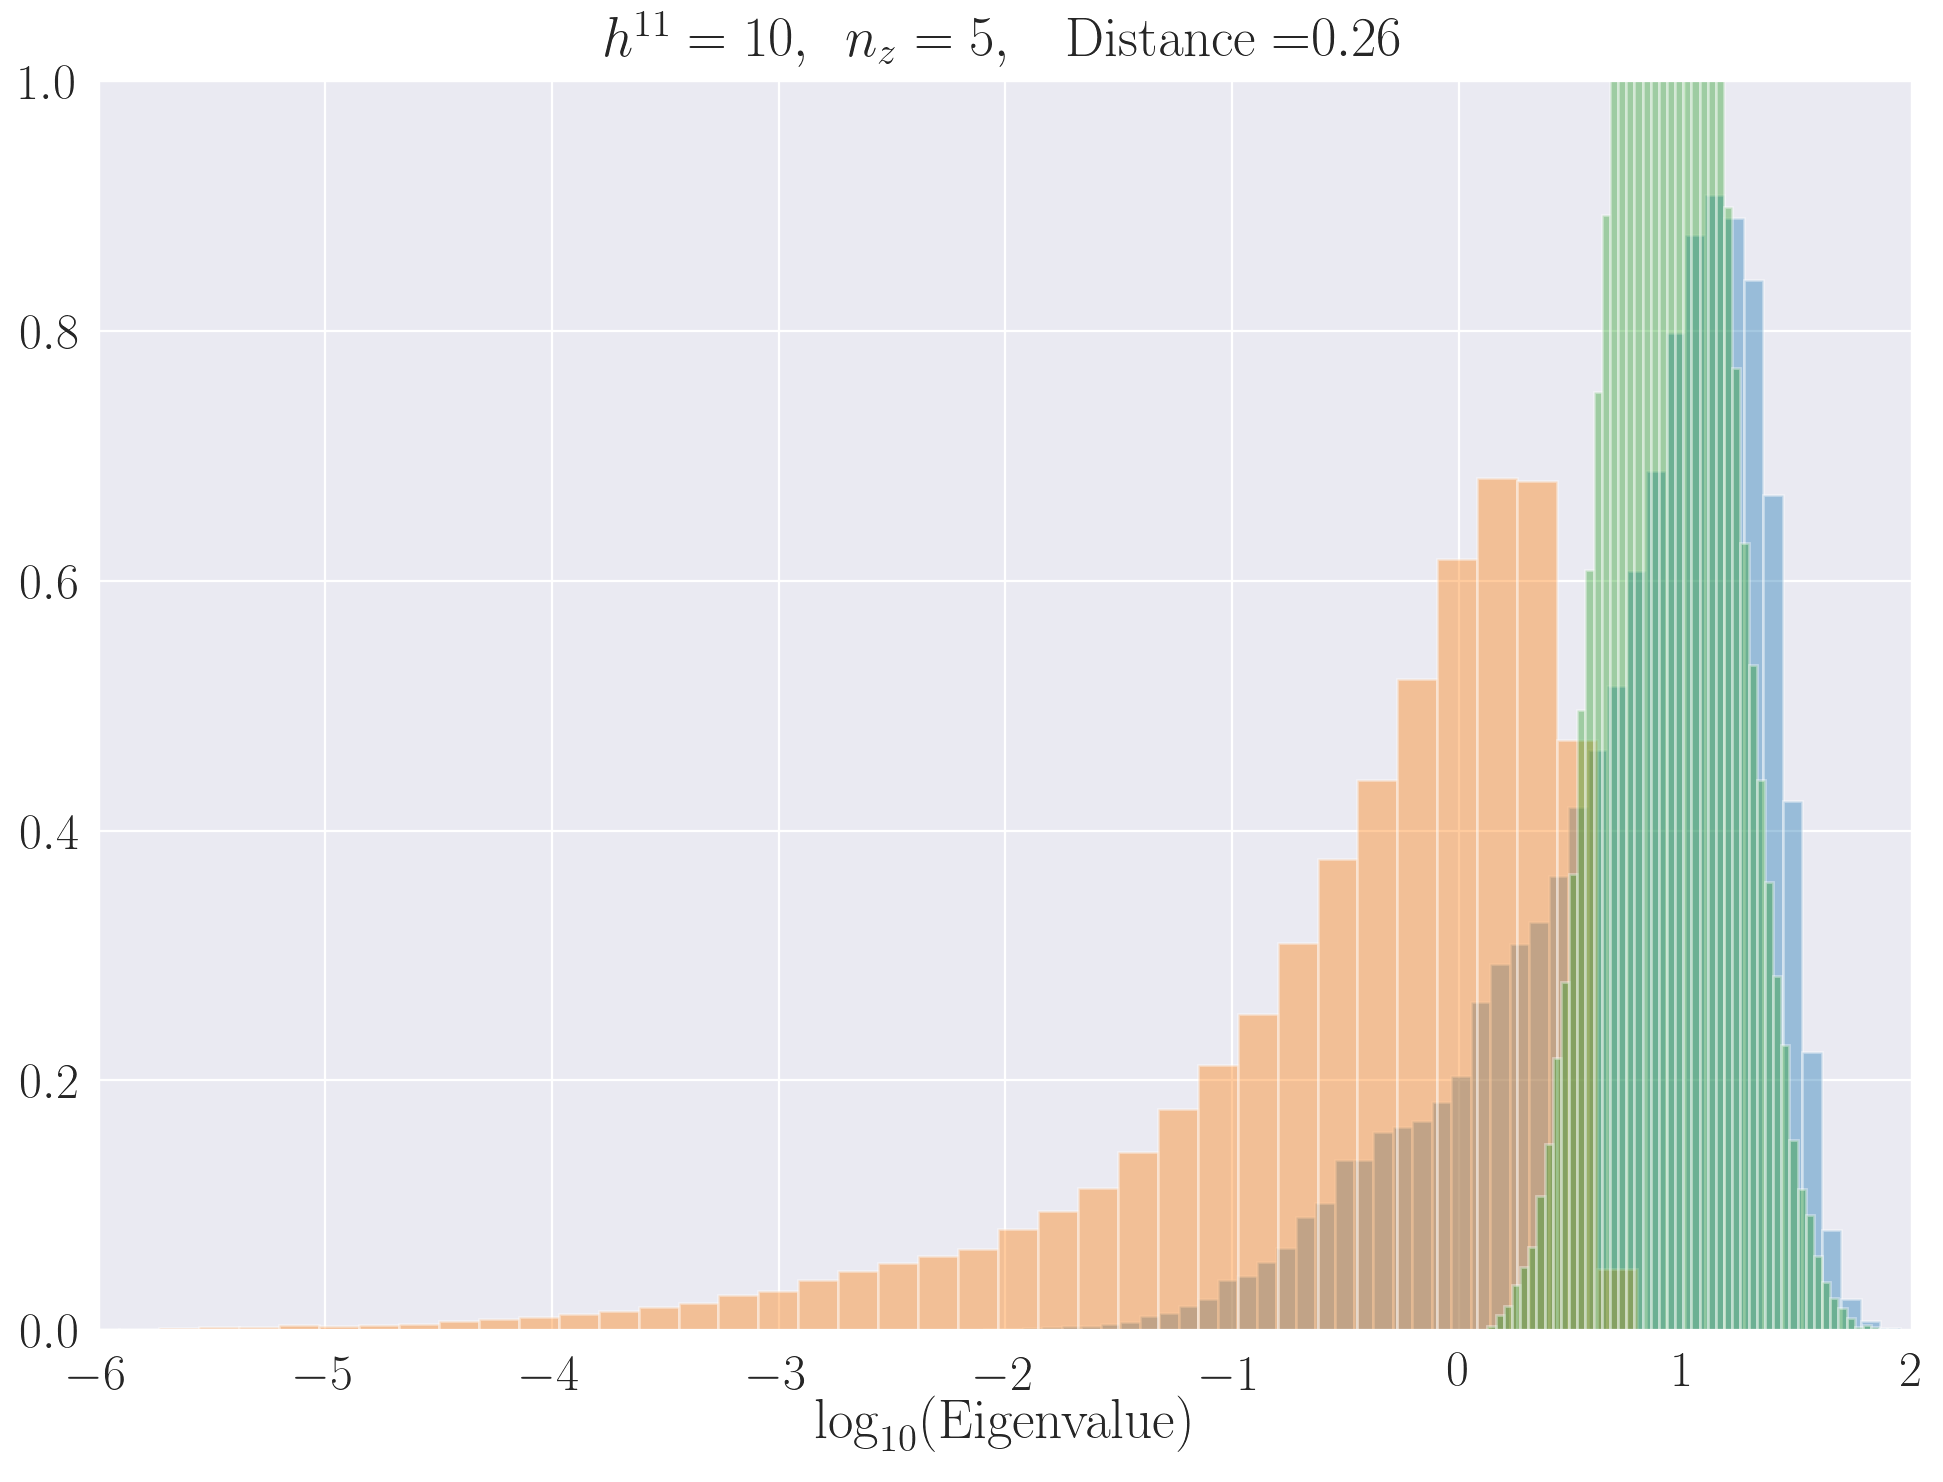

Epoch [40/10000], d_loss: -0.7110, g_loss: 0.0745, Mean D(x): 0.68, Mean D(G(z)): -0.03
(0.31419795113524734, 0.31419795113524734)


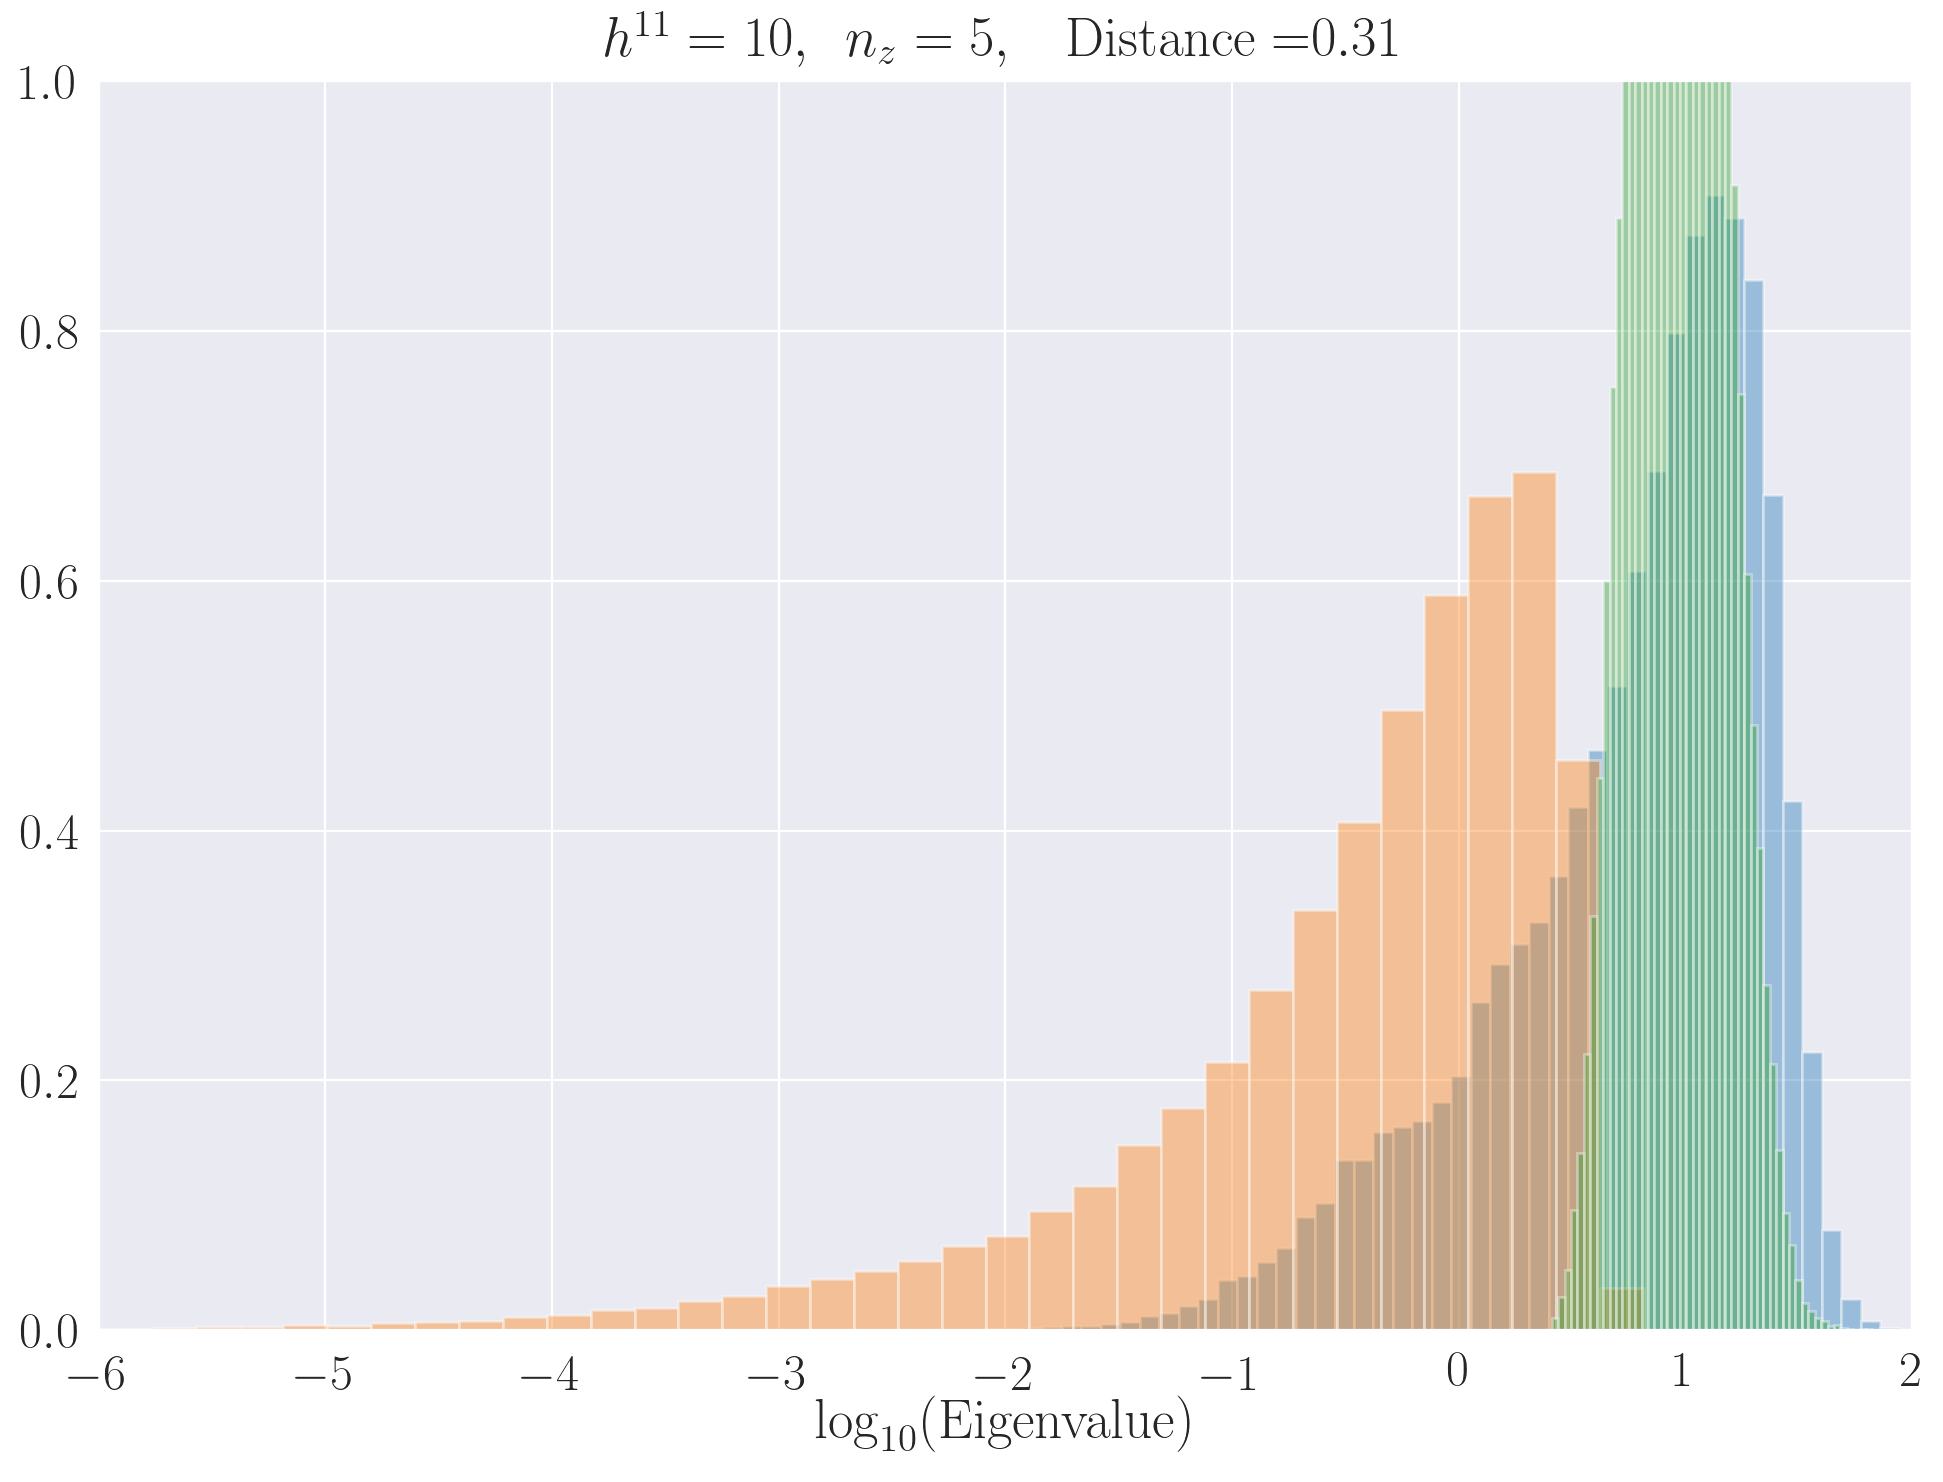

Epoch [60/10000], d_loss: -0.7067, g_loss: 0.0791, Mean D(x): 0.62, Mean D(G(z)): -0.09
(0.29916581394768565, 0.29916581394768565)


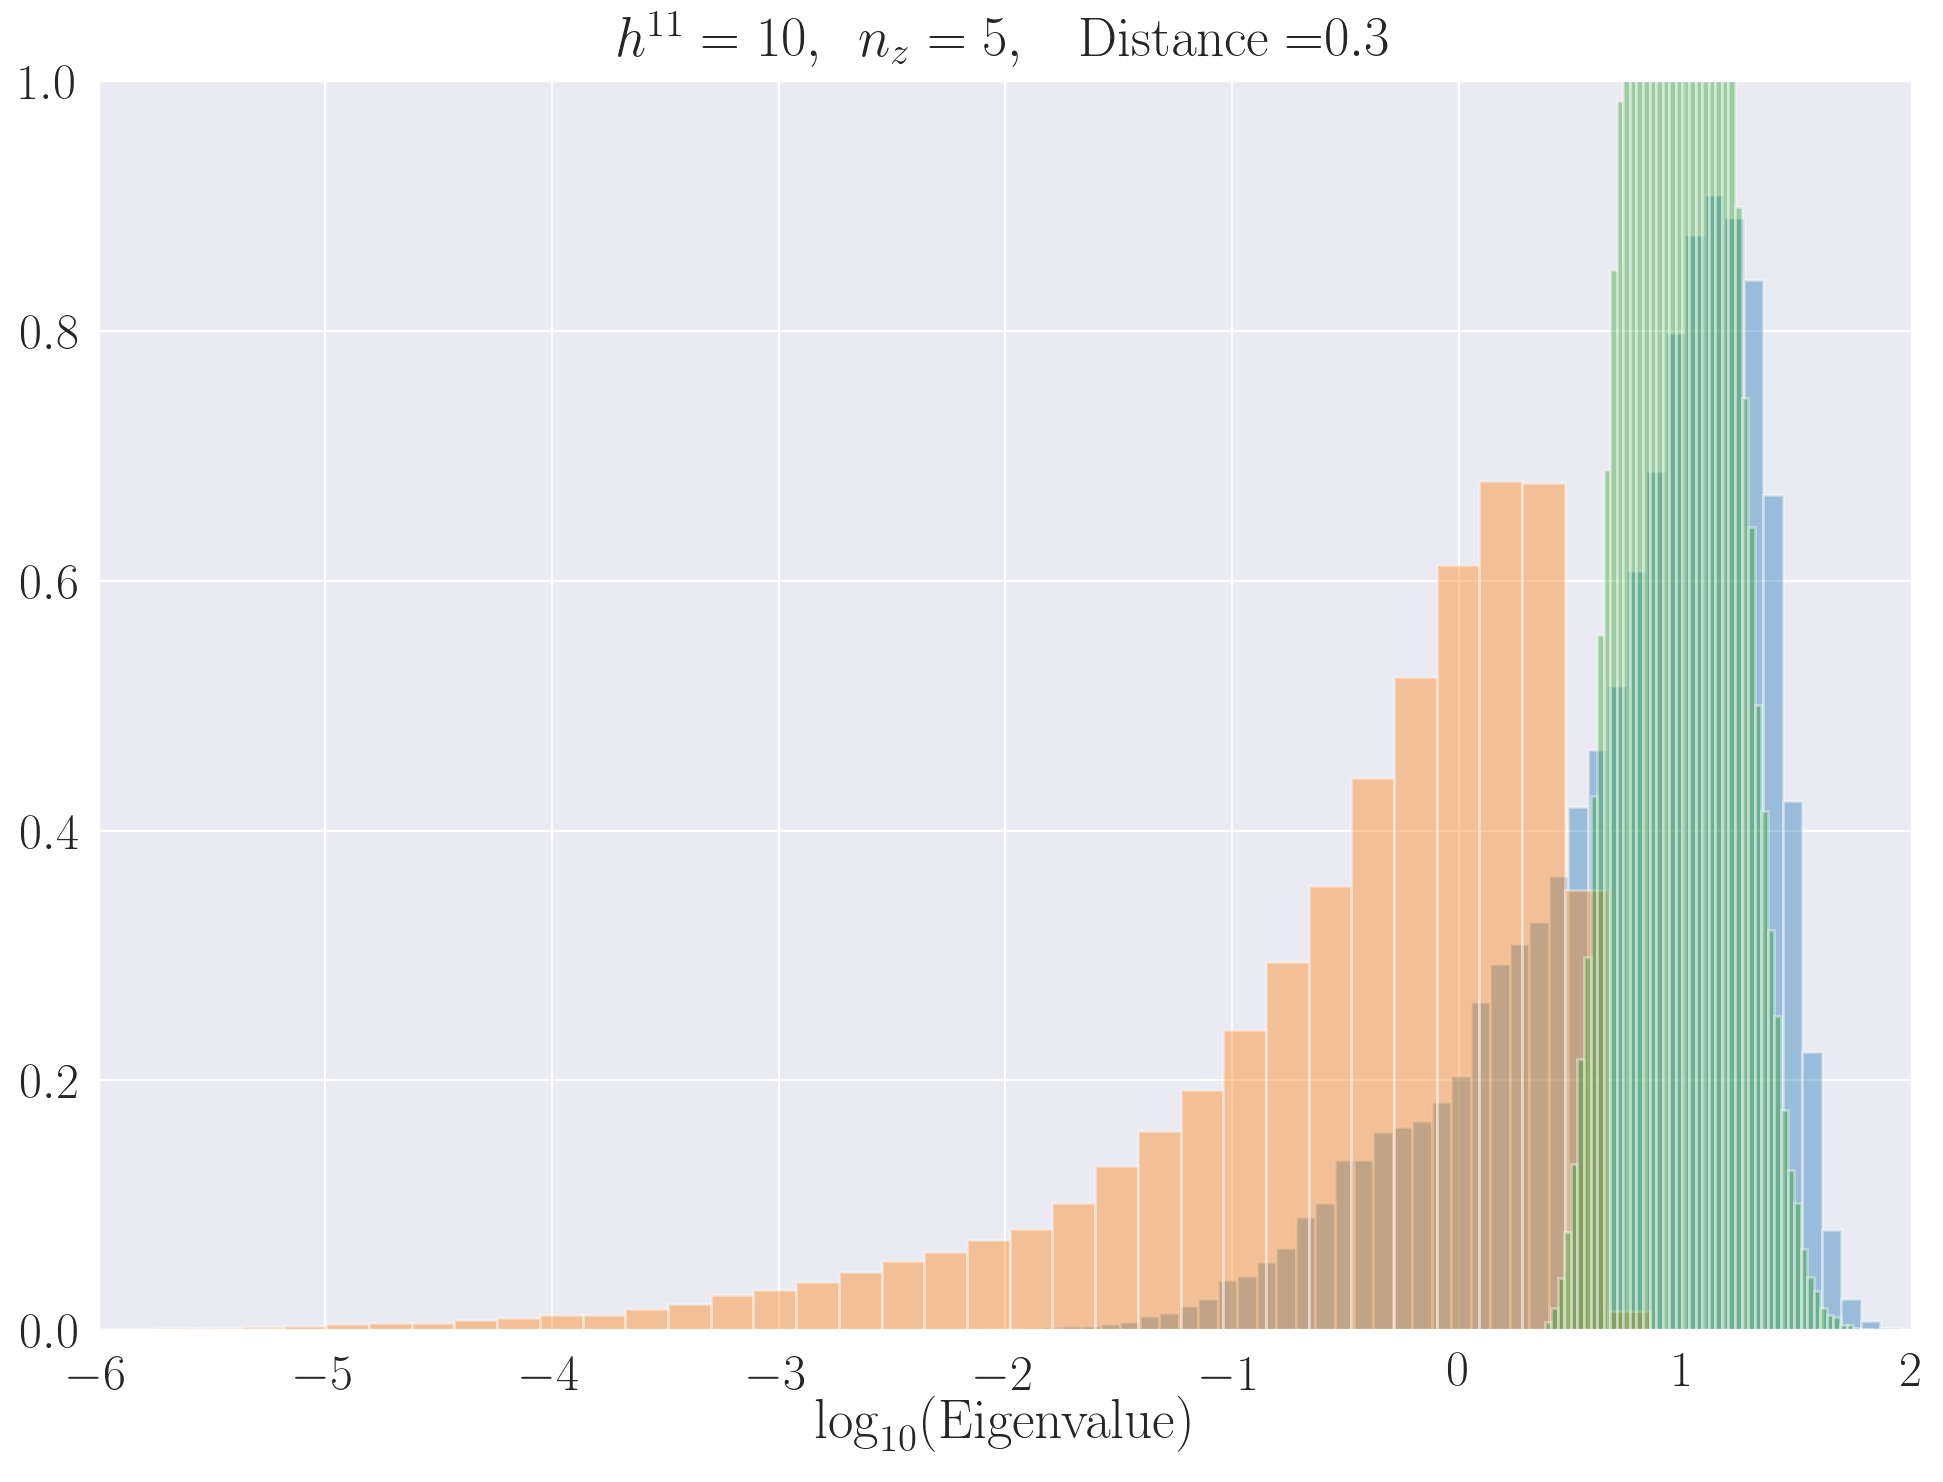

Training ended via keyboard interrupt.


In [28]:
WGAN_list = []

try:
    for epoch in range(N_EPOCHS+1):
        
        # Keep track of critic step
        crit_steps = 0
        
        for batch_number, data in enumerate(data_loader):
            images = data[0]
            batch_size = images.shape[0]
            images = to_var(images.view(batch_size,-1))
            
            # 1) Train critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
                
                # clamp to cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP,CLAMP)
                    
                # compute error on real images
                err_real = torch.mean(critic(images))
                
                # draw random vars, generate fakes, and compute fake errors
                z = to_var(torch.randn(batch_size,nz))
                fake_images = generator(z)
                err_fake = torch.mean(critic(fake_images))
                
                # Minimize this means maximize err_real - err_fake
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                
                # updated critic, remember that!
                crit_steps += 1
            # 2) Train generator
            else:
                critic.zero_grad()
                generator.zero_grad()
                
                # draw random vars, generate fakes, and compute fake errors
                z = to_var(torch.randn(batch_size,nz))
                fake_images = generator(z)
                outputs = critic(fake_images)
                
                # Minimize this so we max its negative
                generator_loss = -torch.mean(outputs)
                
                # Backprop and optimizer generator
                generator_loss.backward()
                generator_optimizer.step()
                
                # Reset the counter so the critic gets the next batch
                crit_steps = 0
                
        ###
        # Print progress as training occurs
        ###

        if (epoch) % 20 == 0:
            WGAN_list.append((h11,epoch,copy.deepcopy(generator).cpu()))
            
            print('Epoch [%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    N_EPOCHS,
                    critic_loss.data,
                    generator_loss.data,
                    err_real.data.mean(),
                    err_fake.data.mean())
            )
            h11, epoch, netG = WGAN_list[-1]
            show_GAN_histogram(netG, 10, 
                       batchSize = 10000, nz=nz, log10=True, dpi=300, display_wishart = True, ylim = (0,1), xlim = (-6,2))
            

except KeyboardInterrupt:
    print("Training ended via keyboard interrupt.")

In [ ]:
show_GAN_image_sequence(WGAN_list, batchSize = batchSize, nz = nz, scale_factor = 1, dpi = 500)



epoch: 0


/home/jim/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/home/jim/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


(0.2564215174018538, 0.2564215174018538)


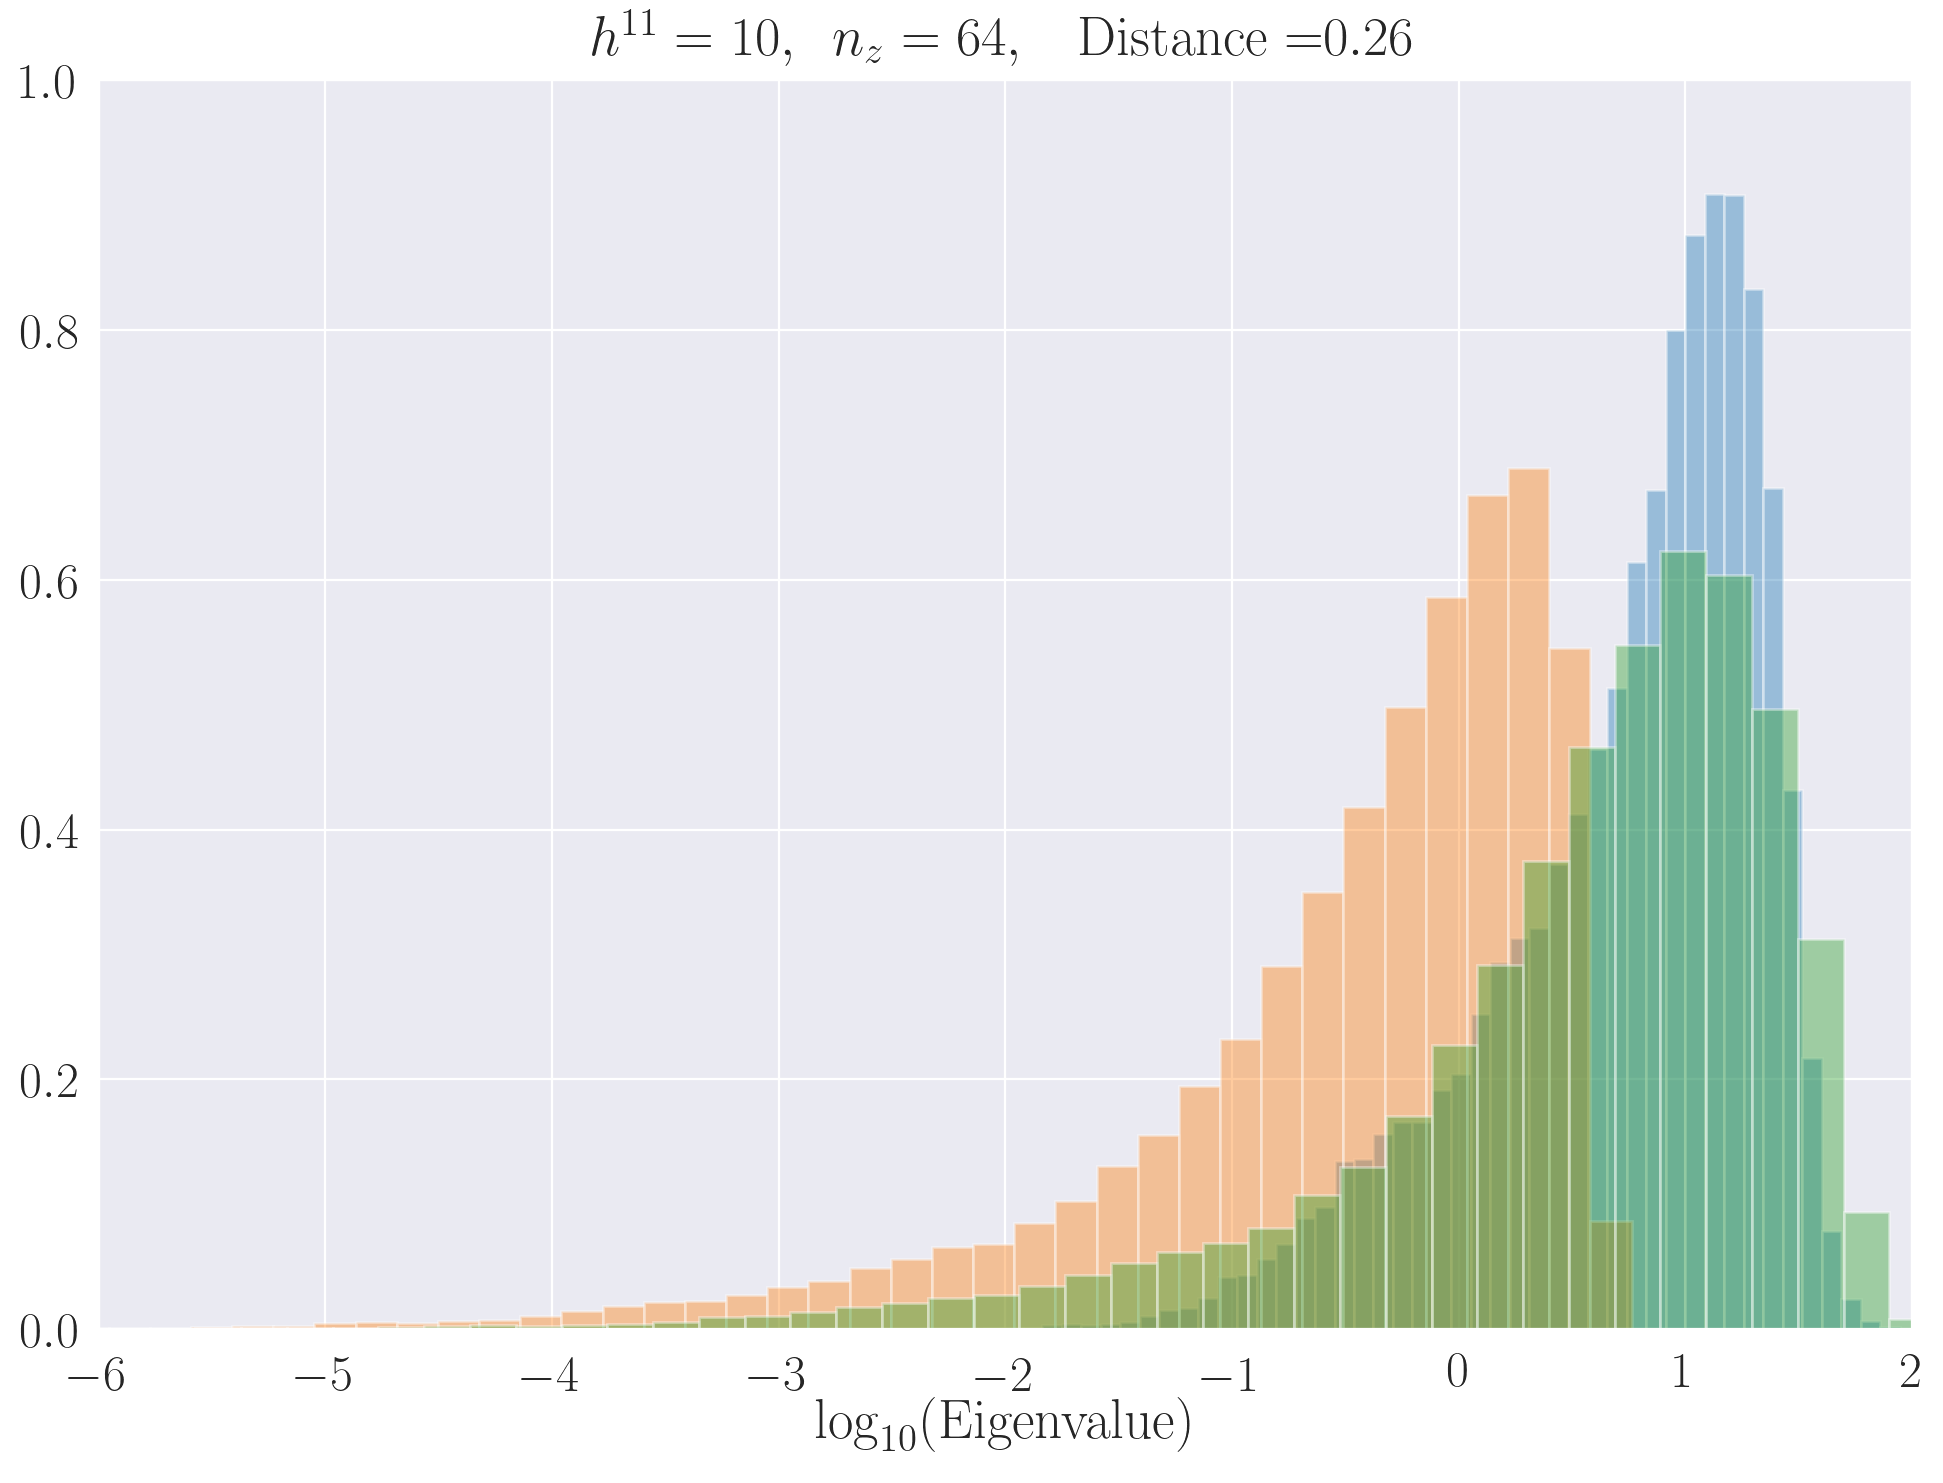

epoch: 5
epoch: 10
epoch: 15
epoch: 20
epoch: 25
epoch: 30
epoch: 35
epoch: 40
epoch: 45
epoch: 50
(nan, nan)


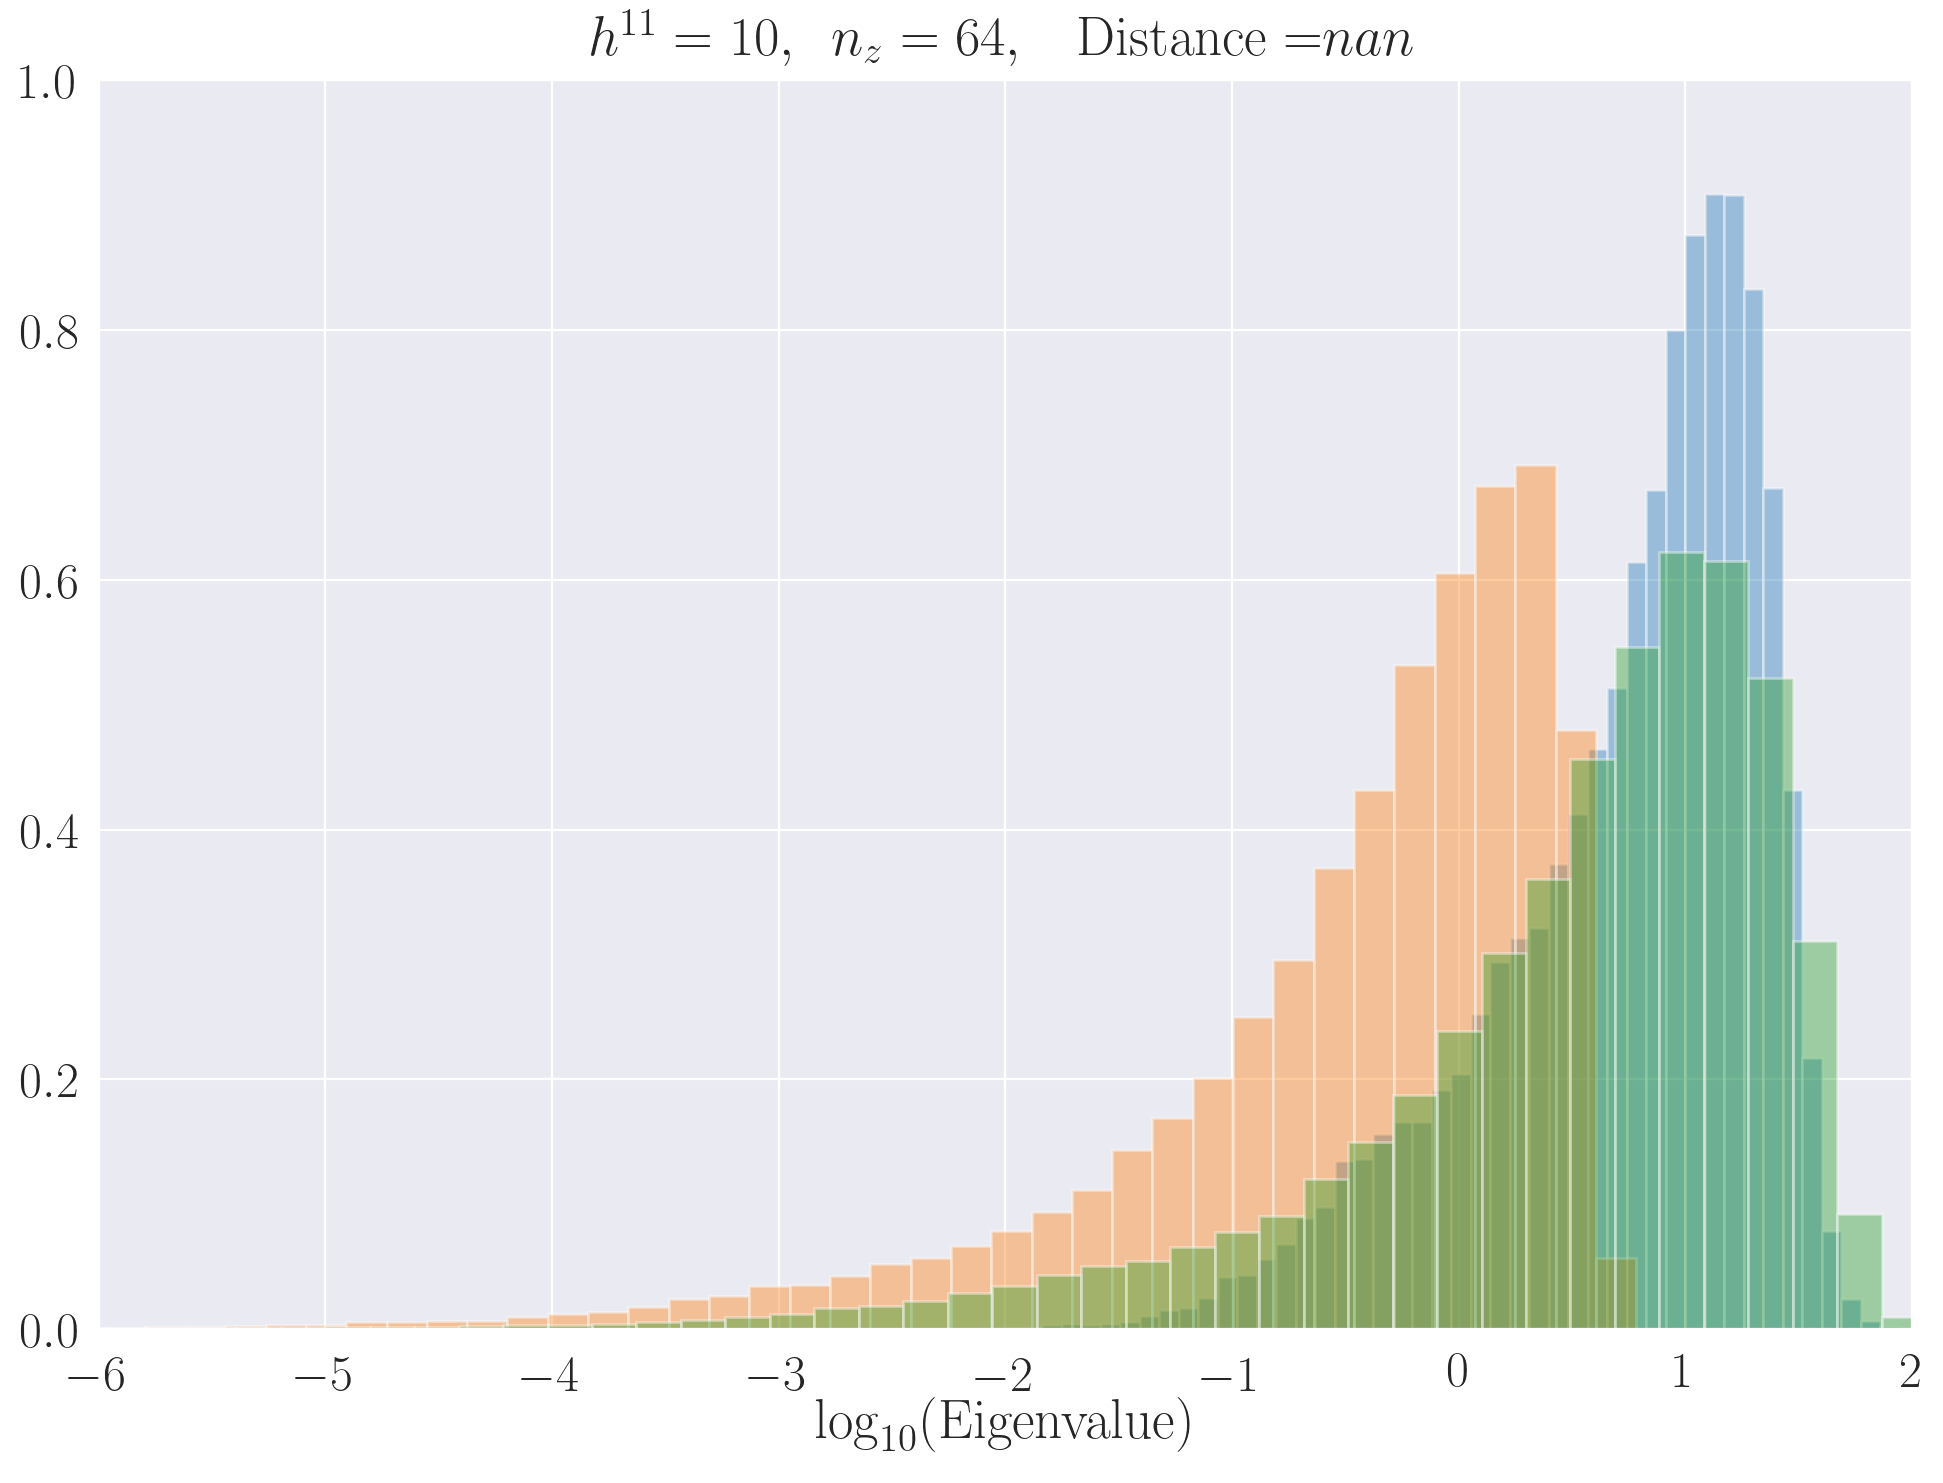

epoch: 55
epoch: 60
epoch: 65
epoch: 70
epoch: 75
epoch: 80
epoch: 85
epoch: 90
epoch: 95
epoch: 100
(nan, nan)


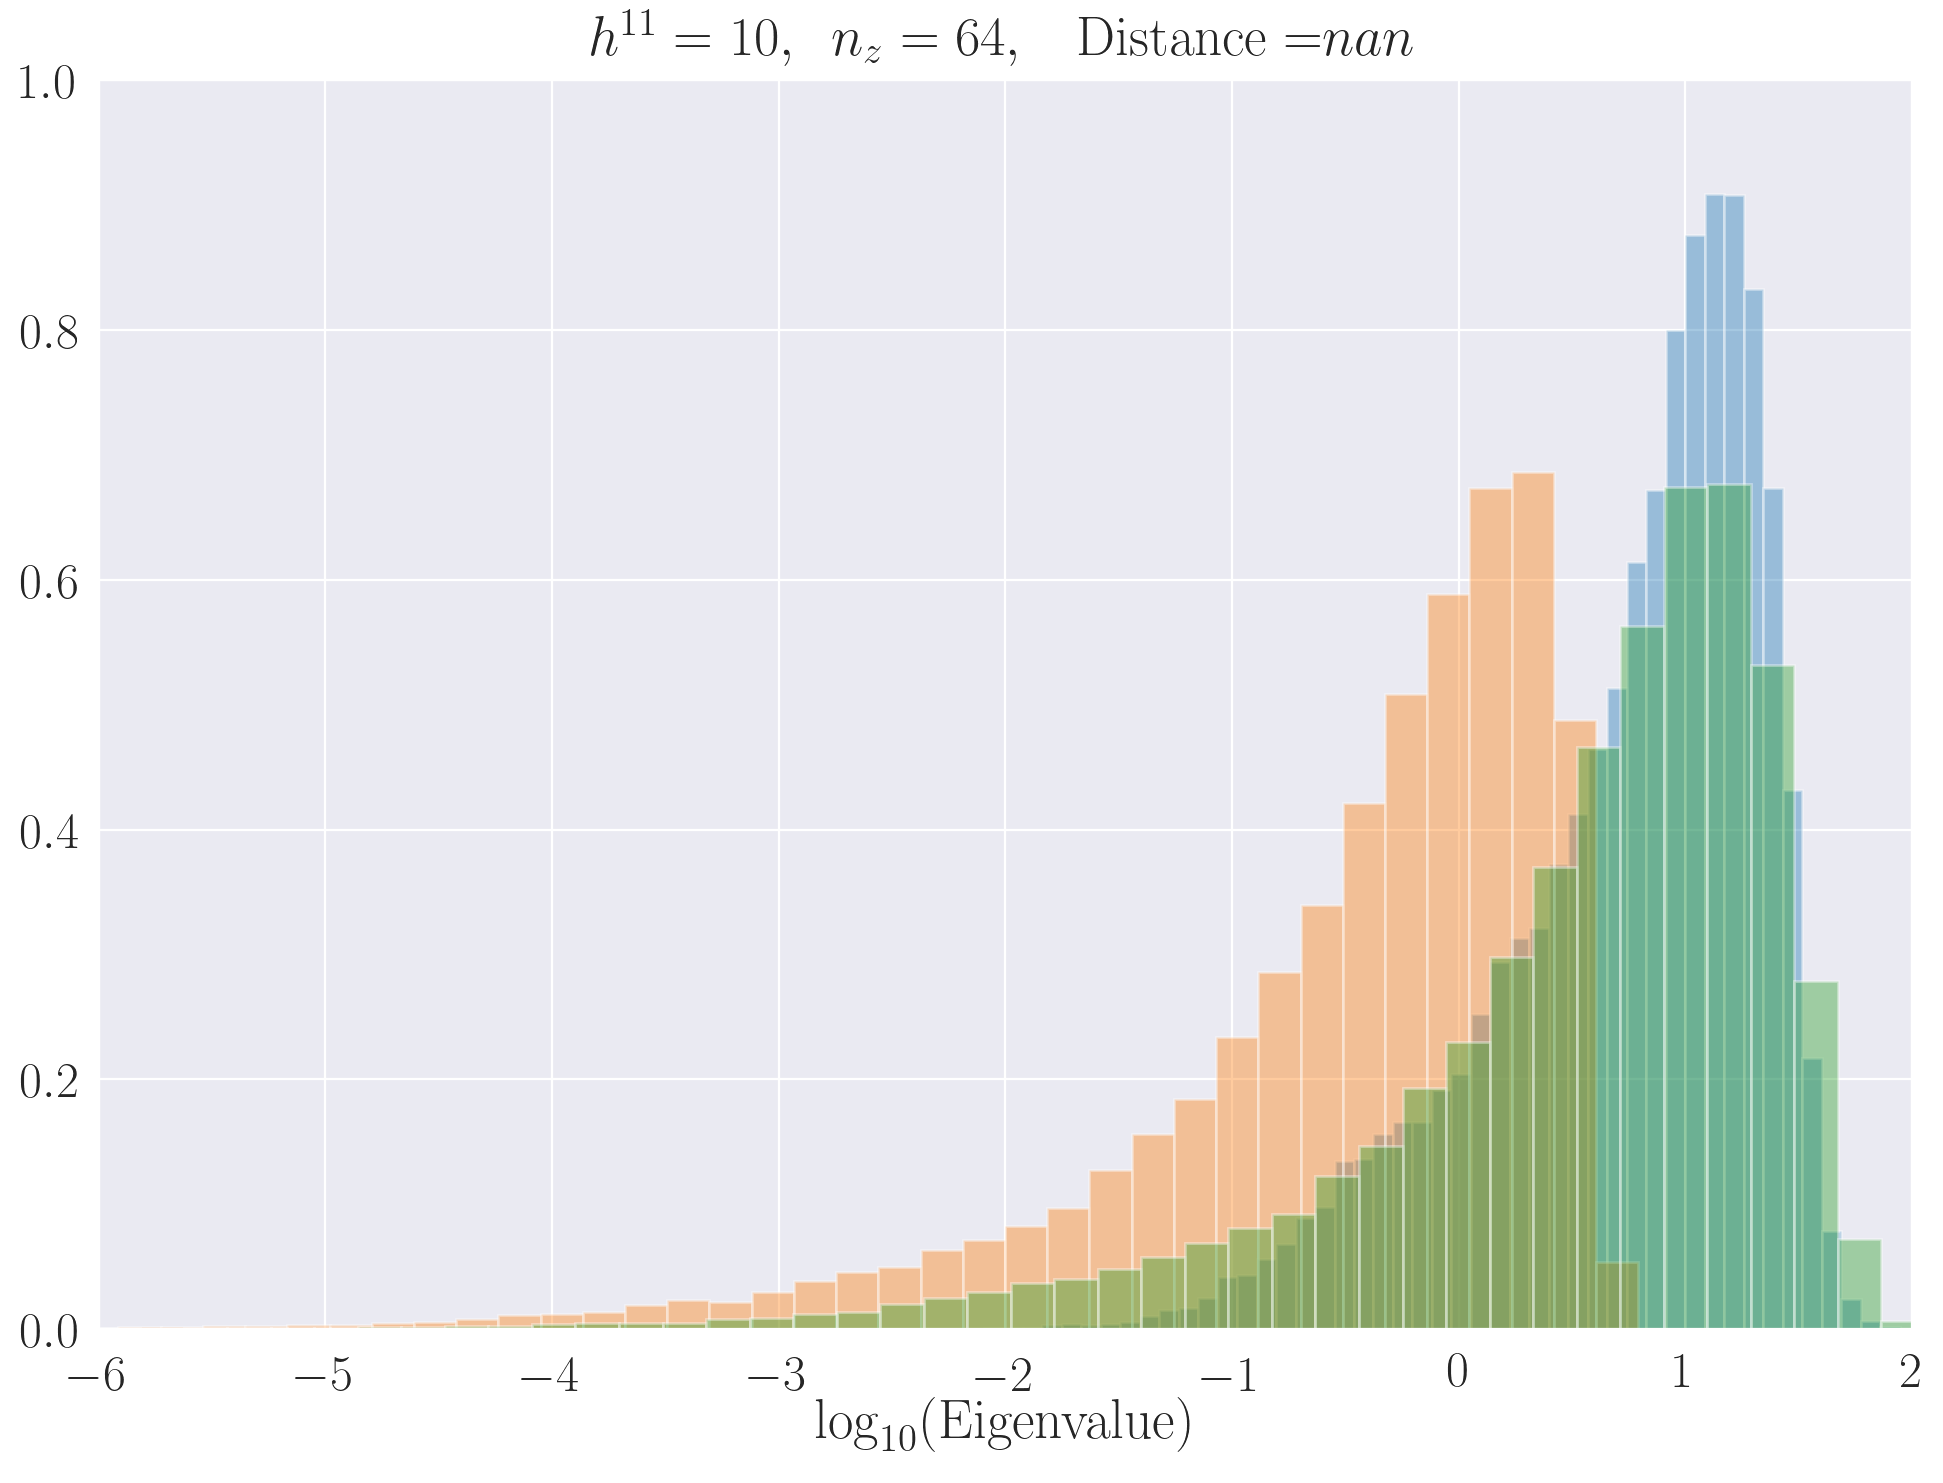

epoch: 105
epoch: 110
epoch: 115
epoch: 120
epoch: 125
epoch: 130
epoch: 135
epoch: 140
epoch: 145
epoch: 150
(nan, nan)


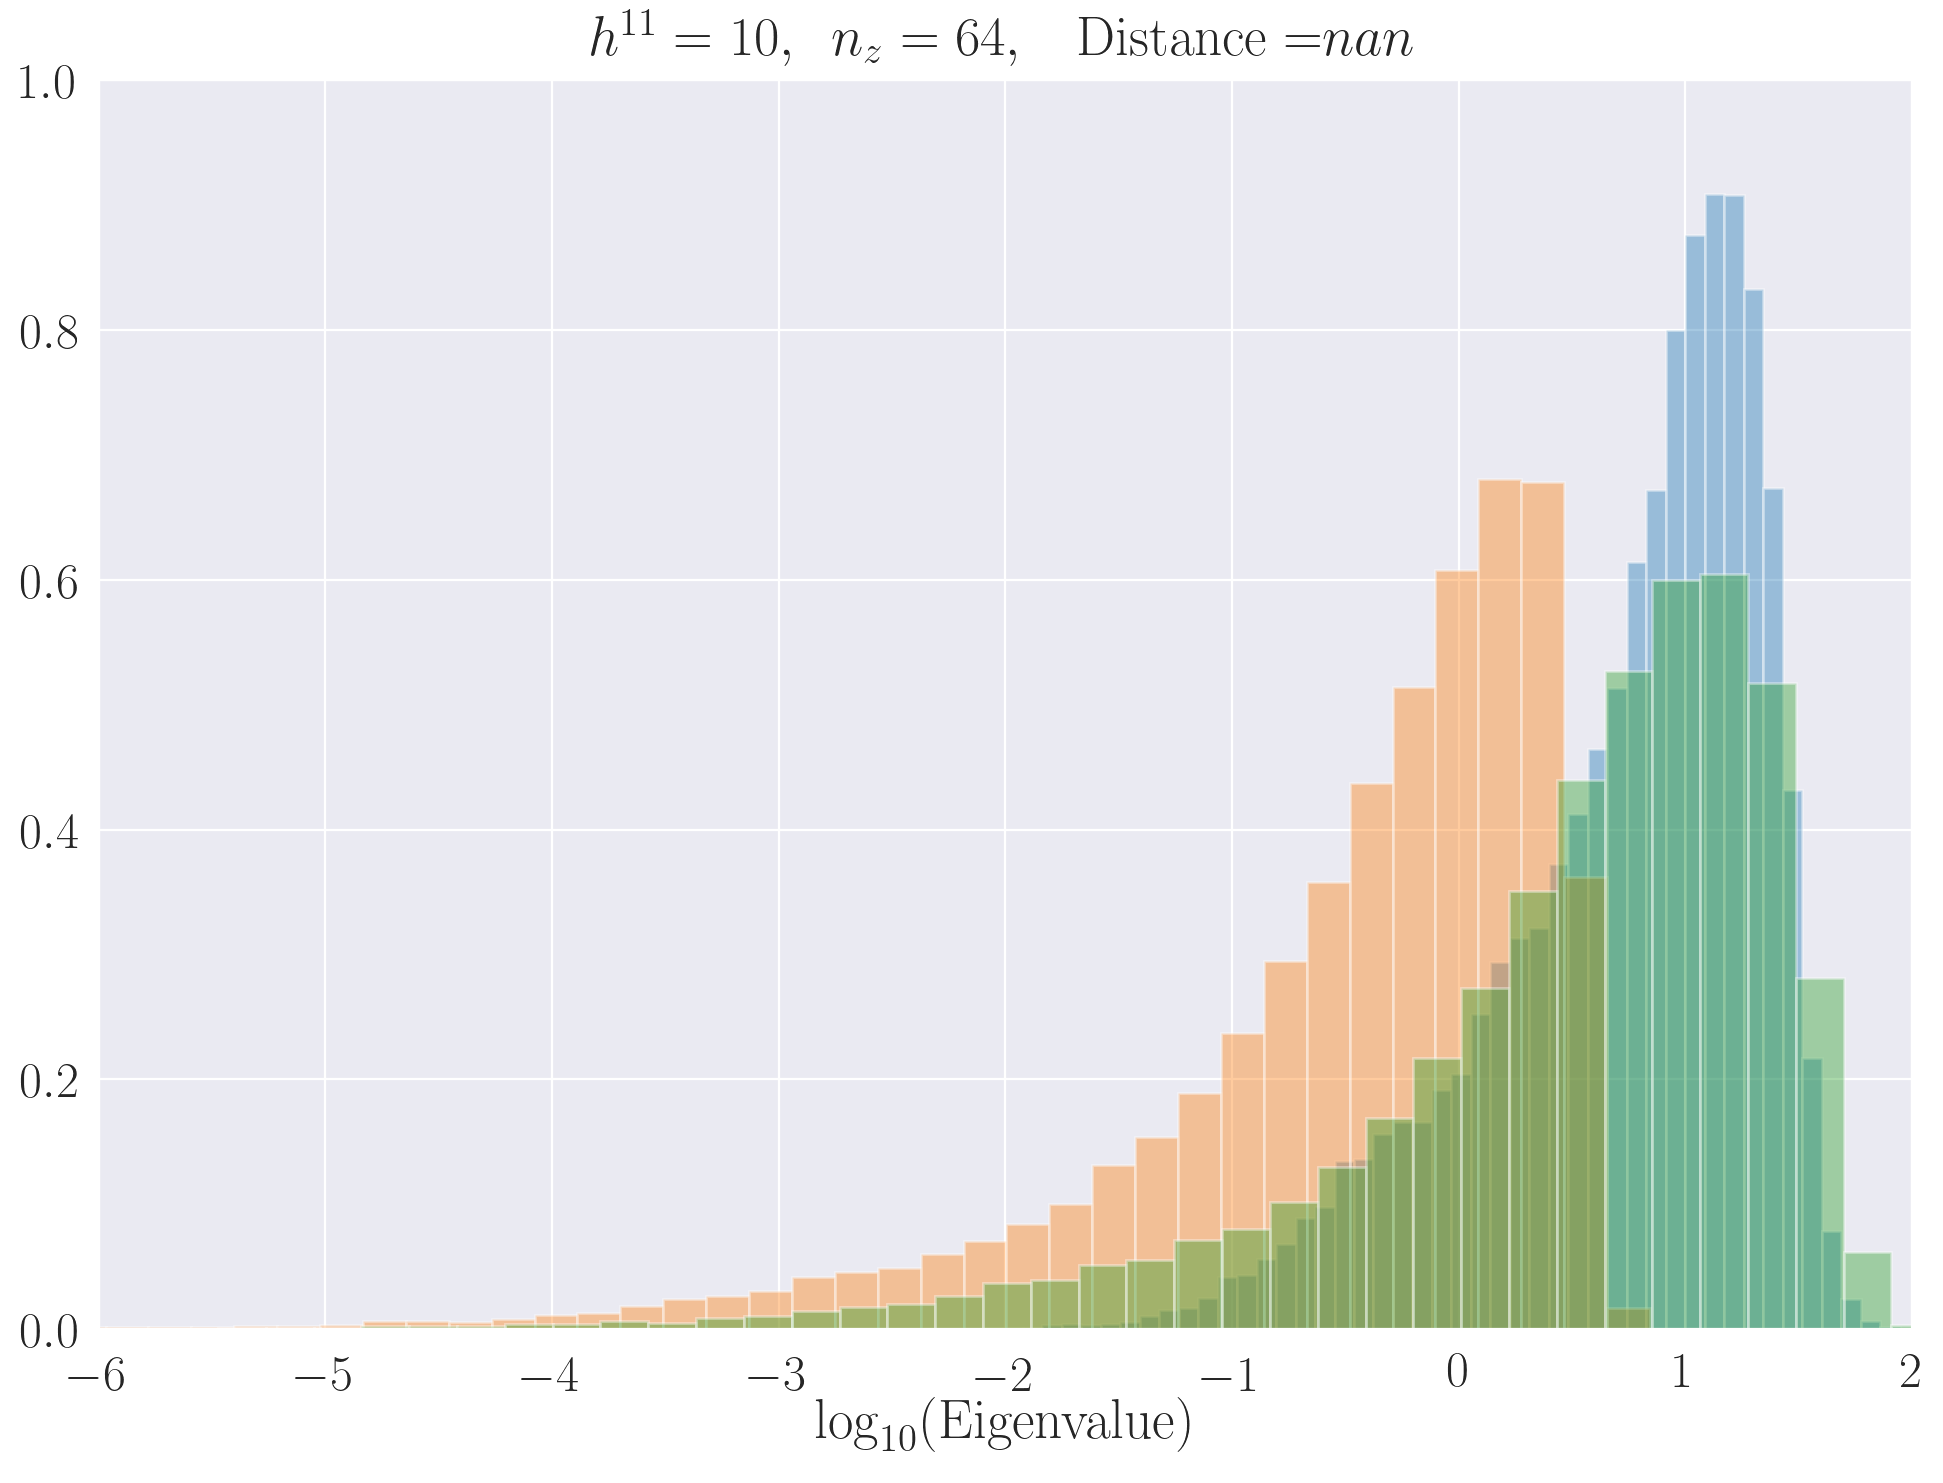

In [31]:
plt.clf()
for h11, epoch, netG in WGAN_list:
    print 'epoch:', epoch
    if epoch % 50 == 0: show_GAN_histogram(netG, 10, 
                       batchSize = 6282, nz=nz, log10=True, dpi=300, display_wishart = True, ylim = (0,1), xlim = (-6,2))